In [ ]:
!pip install virtualenv

In [ ]:
import virtualenv
import subprocess
import os
import sys

notebook_name = "simple_strategies"
virtualenv.cli_run(["venvs/" + notebook_name, "--no-download"])

venv_dir = "venvs/" + notebook_name
python_path = os.path.join(venv_dir, "bin", "python")
display_name = "Python (" + notebook_name + ")"
kernel_name = notebook_name

# Установка ipykernel в venv
subprocess.check_call([os.path.join(venv_dir, "bin", "pip"), "install", "ipykernel"])

# Регистрация ядра
subprocess.check_call([
    python_path, "-m", "ipykernel", "install",
    "--user",
    "--name", kernel_name,
    "--display-name", display_name
])

In [1]:
import sys
print(sys.executable)

/workspace/predictors/univariate/venvs/simple_strategies/bin/python


In [ ]:
import subprocess
import os
import sys

# Путь к pip в активном ядре
pip_path = os.path.join(sys.prefix, "bin", "pip")

# Установка
subprocess.check_call([pip_path, "install", "etna[all]", "pandas", "matplotlib"])

In [51]:
from datetime import datetime
import pandas as pd
from math import floor
import numpy as np
import os
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# ETNA
from etna.datasets import TSDataset
from etna.models import NaiveModel
from etna.metrics import MAE, MAPE, RMSE, SMAPE
from etna.analysis import plot_forecast
from etna.models import (
    MovingAverageModel,
    AutoARIMAModel,
    TBATSModel,
    BATSModel,
    HoltWintersModel,
    StatsForecastARIMAModel,
    StatsForecastAutoThetaModel
)

from etna.models import NonPredictionIntervalContextIgnorantAbstractModel

# Статистические тесты и преобразования
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import seaborn as sns

# Установим читаемый формат для вывода чисел
pd.options.display.float_format = '{:.3f}'.format

In [52]:
def directional_accuracy(actual, predicted):
    """
    Calculates Directional Accuracy by comparing each predicted value's
    direction with the actual value's direction.
    """
    actual_direction = np.sign(actual - np.roll(actual, 1))  # Direction of actual values
    predicted_direction = np.sign(predicted - np.roll(predicted, 1))  # Direction of predictions

    # Ignore the first element (due to np.roll)
    actual_direction[0] = np.nan
    predicted_direction[0] = np.nan

    # Calculate accuracy for elements where both actual and predicted directions are not NaN
    mask = ~np.isnan(actual_direction) & ~np.isnan(predicted_direction)

    return np.mean(actual_direction[mask] == predicted_direction[mask]) * 100

# Загрузка данных

In [57]:
def load_series_map(series_dir="../../data/series"):
    series_map = {}
    series_path = Path(series_dir)
    if not series_path.exists():
        raise FileNotFoundError(f"Папка не найдена: {series_dir}")
    for csv_file in series_path.glob("*.csv"):
        ticker = csv_file.stem.upper()
        df = pd.read_csv(csv_file)
        if "timestamp" not in df.columns or "close" not in df.columns:
            raise ValueError(f"{csv_file.name} не содержит 'timestamp' или 'close'")
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
        df = df[["timestamp", "close"]].sort_values("timestamp").reset_index(drop=True)
        series_map[ticker] = df
    return series_map

In [58]:
series_map = load_series_map("../../data/series")

In [59]:
series = {}
for ticker, df in series_map.items():
    tmp = df.copy()
    tmp["timestamp"] = pd.to_datetime(tmp["timestamp"], utc=True)
    tmp = tmp.rename(columns={"close": "target"})
    tmp["segment"] = ticker
    tmp = tmp[["timestamp", "segment", "target"]]

    # 1) Сначала вручную реиндексируем по business-day (freq="B") и заполним пропуски ffill→bfill
    tmp = tmp.set_index("timestamp")
    all_biz = pd.date_range(start=tmp.index.min(), end=tmp.index.max(), freq="B", tz="UTC")
    tmp = tmp.reindex(all_biz)
    tmp["target"] = tmp["target"].ffill().bfill()
    tmp = tmp.reset_index().rename(columns={"index": "timestamp"})
    tmp["segment"] = ticker

    # 2) Строим одно-сегментный TSDataset с freq="B"
    ts = TSDataset(tmp, freq="B")

    # 3) Разбиваем 95% / 5% по количеству точек
    n_points = df.shape[0]
    train_size = int(n_points * 0.95)
    test_size = n_points - train_size

    train_ts, test_ts = ts.train_test_split(test_size=test_size)

    # Проверим, что в конце train нет NaN
    df_train_flat = train_ts.to_pandas(flatten=True)
    last_val = df_train_flat.iloc[-1]['target']
    assert not pd.isna(last_val), f"NaN в последнем значении train для {ticker}"

    series[ticker] = (ts, train_ts, test_ts)

# Native Repeat

In [60]:
class NativeRepeatModel(NonPredictionIntervalContextIgnorantAbstractModel):
    """
    Кастомная наивная модель:
      - При fit(train_ts) сохраняет последнее значение target из train_ts.
      - При forecast(test_ts, prediction_size) строит прогноз:
          preds[0] = last_train_value,
          preds[i] = actual_test_target[i-1] для i >= 1,
        и обязательно возвращает TSDataset с тем же индексом timestamp, что и test_ts.
    """

    def __init__(self):
        super().__init__()
        self.last_value = None
        self._freq = None
        self.segment = None

    def fit(self, ts: TSDataset) -> None:
        """
        ts — это train-часть (одно-сегментный TSDataset).
        Сохраняем последнее значение target и freq.
        """
        self._freq = ts.freq
        df_flat = ts.to_pandas(flatten=True)
        self.segment = ts.segments[0]
        # Берём последнее значение из train
        self.last_value = df_flat["target"].iloc[-1]

    def forecast(self, ts: TSDataset, prediction_size: int) -> TSDataset:
        """
        ts — это test-часть (одно-сегментный TSDataset).
        prediction_size можно игнорировать, потому что ts уже содержит
        нужные timestamps теста.
        """
        # Извлекаем список тестовых timestamp из ts.df.index
        # ts.df имеет MultiIndex (timestamp, segment) в старших версиях ETNA,
        # а в новых — index = timestamp, columns = (segment, feature). 
        # Чтобы корректно взять индексы, приведем ts.to_pandas(flatten=True):
        df_test_flat = ts.to_pandas(flatten=True).reset_index()
        test_timestamps = df_test_flat["timestamp"].tolist()

        # Real test values (на случай, если prediction_size > 1)
        actual_test_values = df_test_flat["target"].values
        n_test = len(actual_test_values)

        # Собираем массив preds:
        preds = [self.last_value]
        if n_test > 1:
            shifted = actual_test_values[:-1].tolist()
            preds.extend(shifted)

        # Построим DataFrame прогноза, используя точно те же timestamps и segment
        df_forecast = pd.DataFrame({
            "timestamp": test_timestamps,
            "target": preds,
            "segment": self.segment
        })

        # Возвращаем одно-сегментный TSDataset с тем же freq
        return TSDataset(df=df_forecast, freq=self._freq)

    def predict(self, ts: TSDataset, prediction_size: int) -> TSDataset:
        # Просто проксируем в forecast
        return self.forecast(ts, prediction_size)

    def get_model(self) -> str:
        return "NativeRepeatModel"

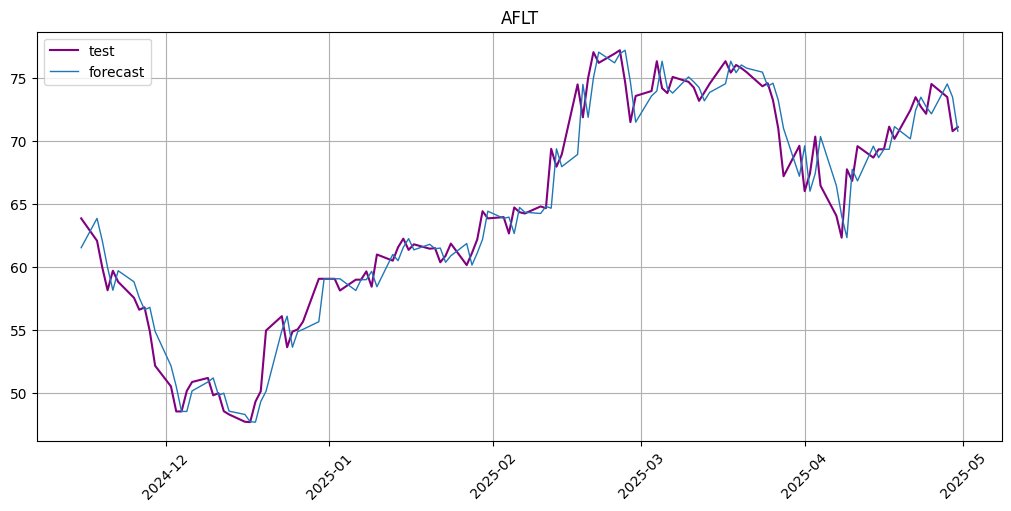

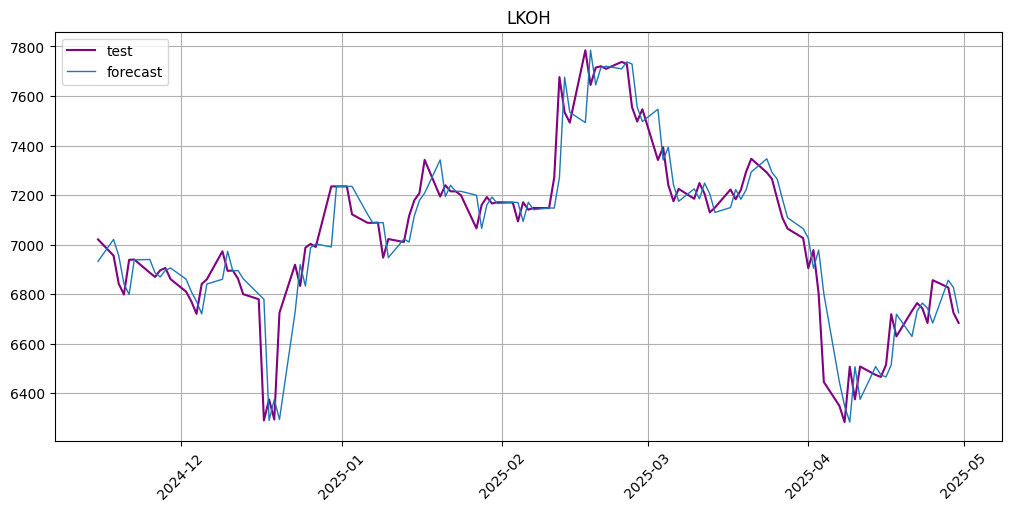

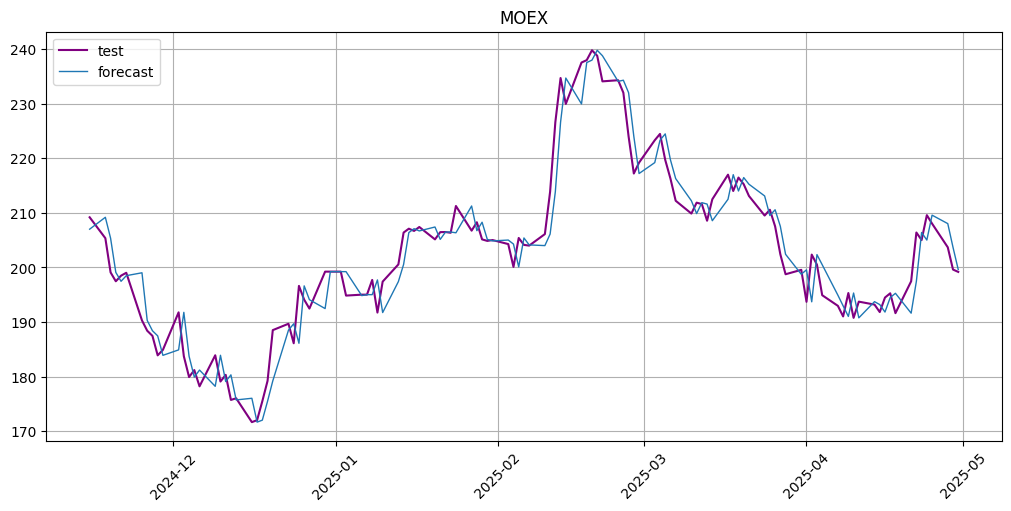

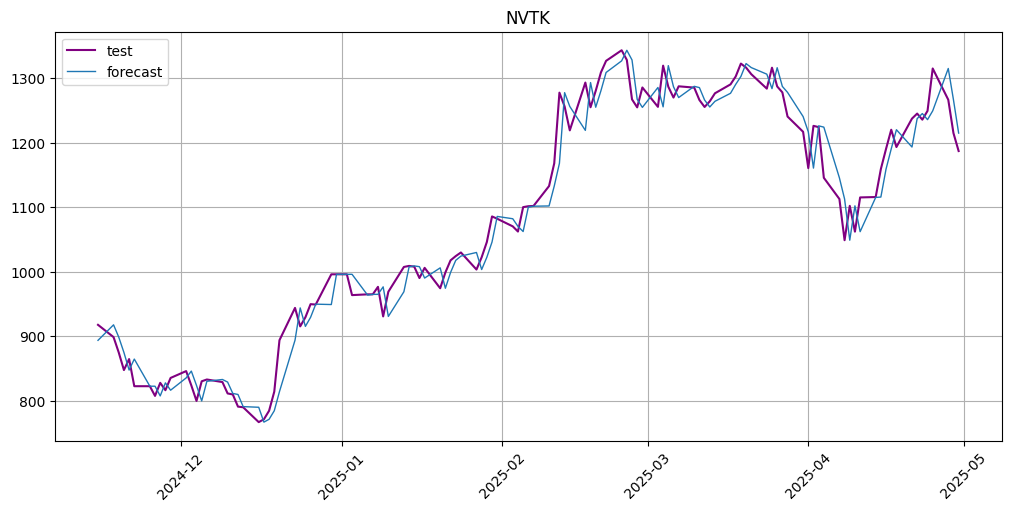

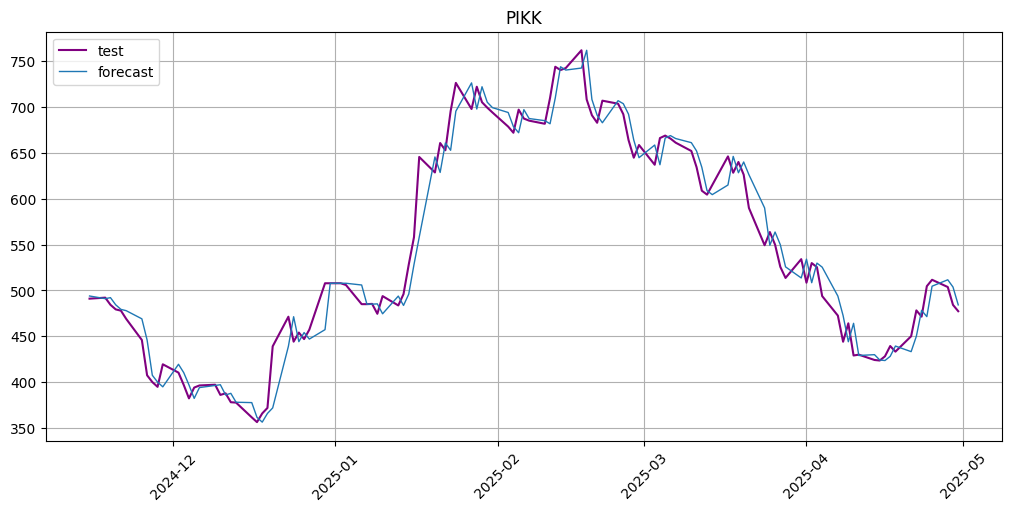

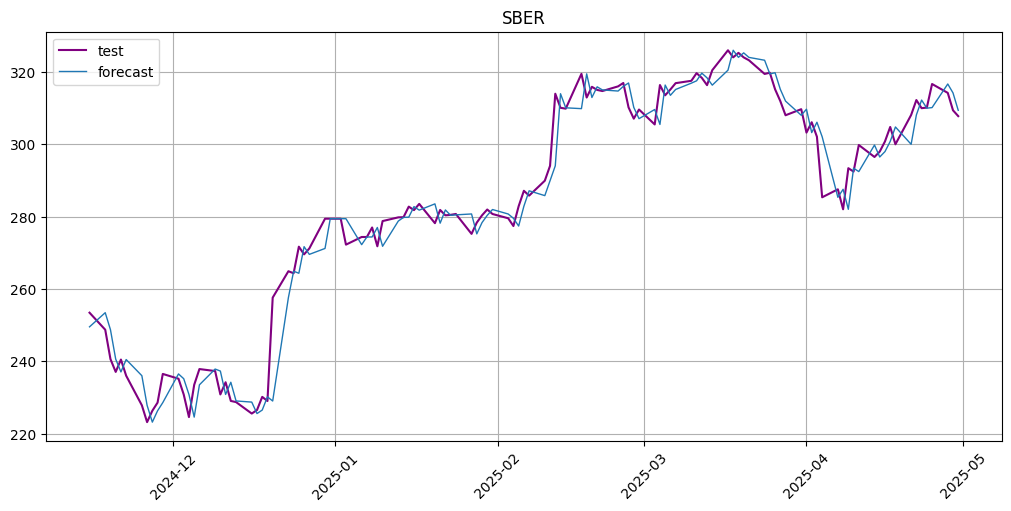

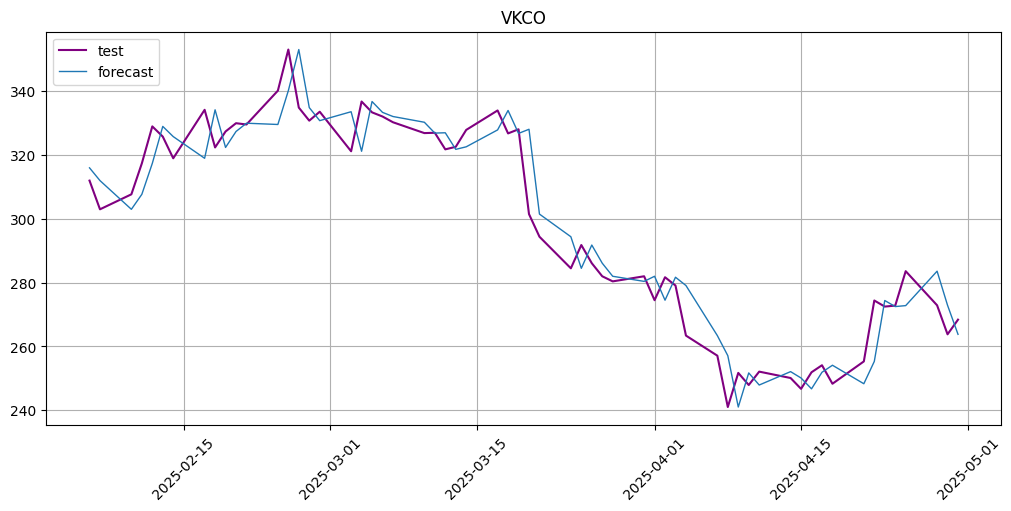

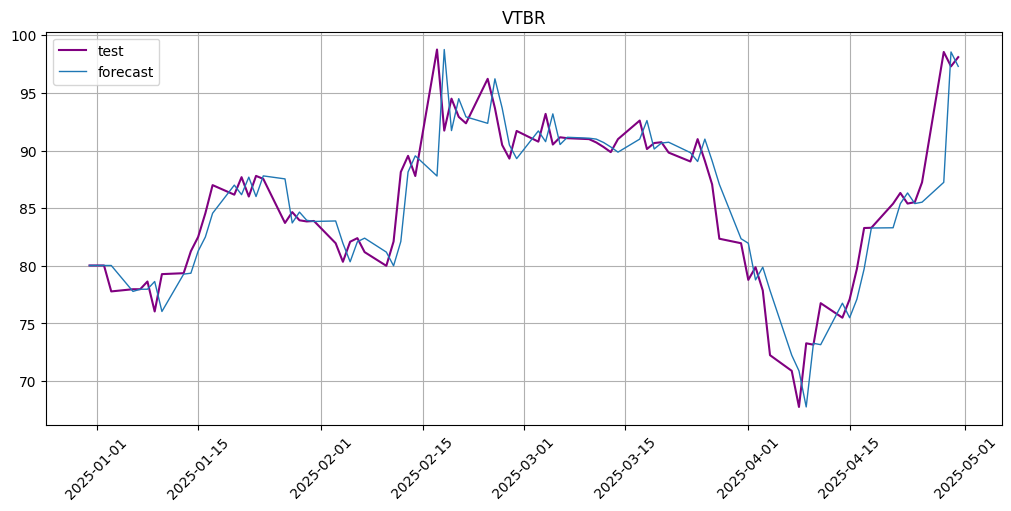

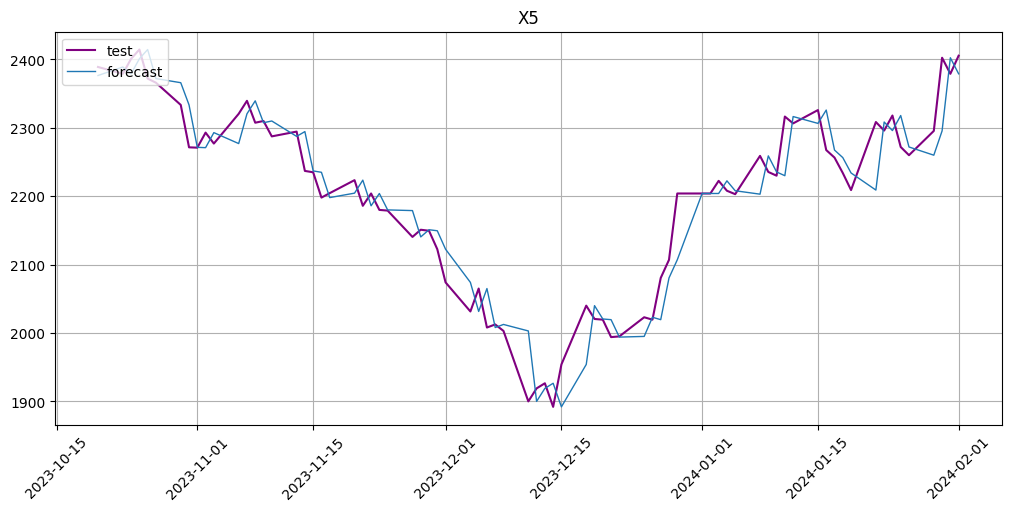

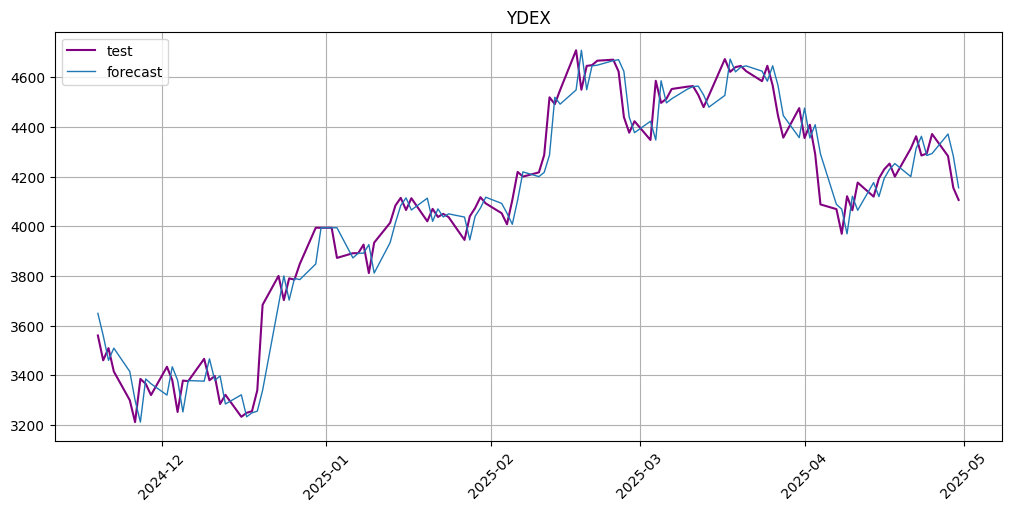

In [67]:
# Словари для хранения результатов
results_map = {}

for ticker, (ts, train_ts, test_ts) in series.items():
    #print(f"\n--- Тикер {ticker} ---")
    
    # 1) Инициализируем и обучаем кастомную модель
    model = NativeRepeatModel()
    model.fit(train_ts)
    
    # 2) Выполняем прогноз на test_size точек и замеряем время
    df_test = test_ts.to_pandas(flatten=False)
    test_size = df_test.shape[0]
    
    start_time = time.time()
    forecast_ts = model.forecast(ts=test_ts, prediction_size=test_size)
    end_time = time.time()
    forecast_time = ((end_time - start_time) / test_size) * 1000 # Время в секундах на один прогноз
    
    # 3) Собираем прогноз и реальные значения в pandas.Series
    df_pred = forecast_ts.to_pandas(flatten=True)
    df_true = test_ts.to_pandas(flatten=True)
    
    y_true = df_true["target"].values
    y_pred = df_pred["target"].values

    # 4) Считаем метрики
    mae_v   = MAE()(test_ts, forecast_ts)
    mape_v  = MAPE()(test_ts, forecast_ts)
    rmse_v  = RMSE()(test_ts, forecast_ts)
    smape_v = SMAPE()(test_ts, forecast_ts)
    da_v = directional_accuracy(y_true, y_pred)
    
    # 5) Сохраняем метрики и прогноз
    results_map[ticker] = {
        "MAE": mae_v[ticker],
        "MAPE (%)": mape_v[ticker],
        "RMSE": rmse_v[ticker],
        "SMAPE (%)": smape_v[ticker],
        "DA (%)": da_v,
        "Forecast time (s)": forecast_time
    }
    
    plot_forecast(forecast_ts, test_ts)

In [68]:
# 7) Собираем сводную таблицу метрик
metrics_df = pd.DataFrame.from_dict(results_map, orient="index")
metrics_df.loc["AVERAGE"] = metrics_df.mean(numeric_only=True)
metrics_df = metrics_df.round(3)

print("\n=== Итоговая таблица метрик ===")
display(metrics_df)


=== Итоговая таблица метрик ===


MAE  MAPE (%)    RMSE  SMAPE (%)  DA (%)  Forecast time (s)
AFLT     1.374     2.134   1.802      2.140  38.983              0.117
LKOH    81.029     1.163 118.324      1.163  41.525              0.079
MOEX     3.245     1.606   4.161      1.608  42.373              0.076
NVTK    24.808     2.286  31.931      2.294  52.542              0.076
PIKK    16.106     2.983  21.560      2.998  49.153              0.072
SBER     3.872     1.396   5.504      1.403  40.678              0.072
VKCO     6.943     2.354   8.772      2.346  40.678              0.123
VTBR     1.884     2.200   2.765      2.214  44.186              0.092
X5      28.760     1.317  38.887      1.320  40.541              0.103
YDEX    71.786     1.794  91.462      1.799  40.517              0.076
AVERAGE 23.981     1.923  32.517      1.928  43.118              0.089

# Simple Moving Average

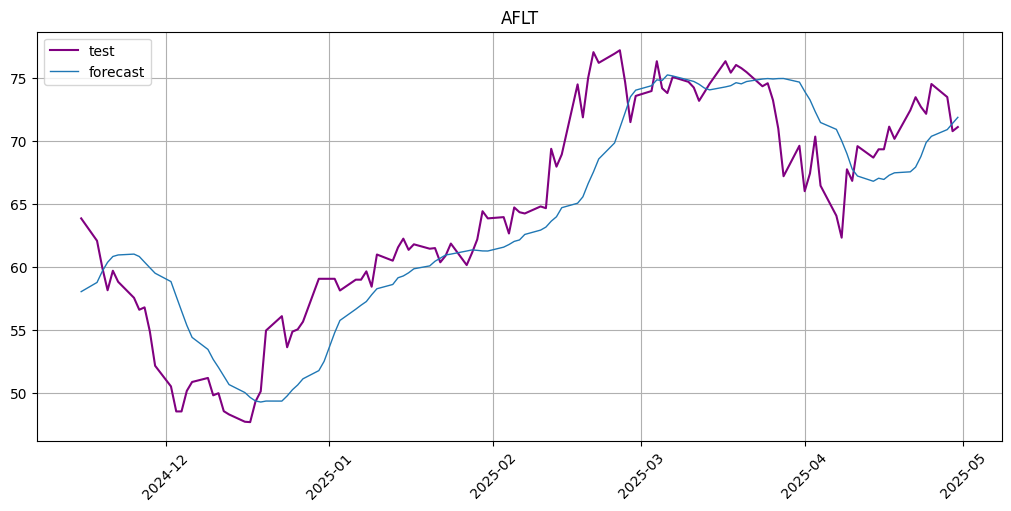

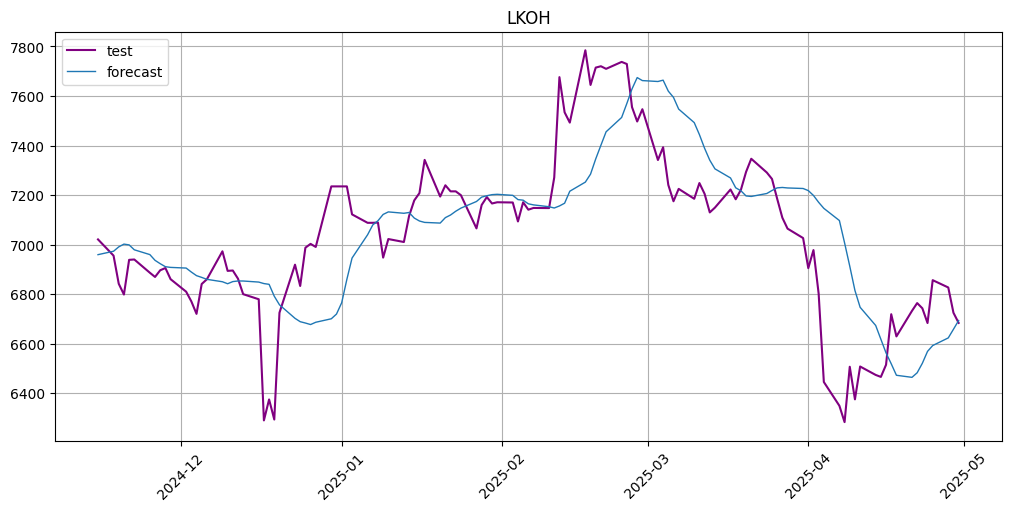

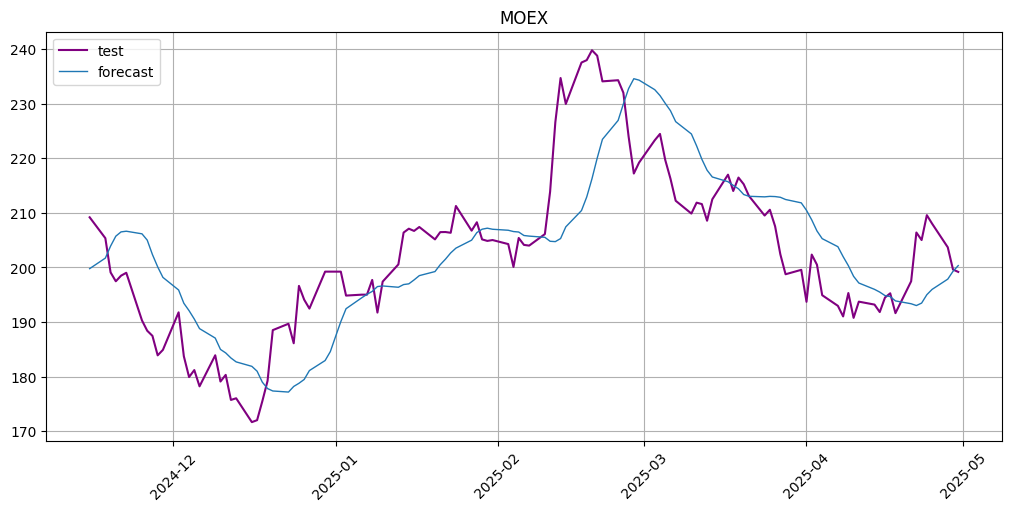

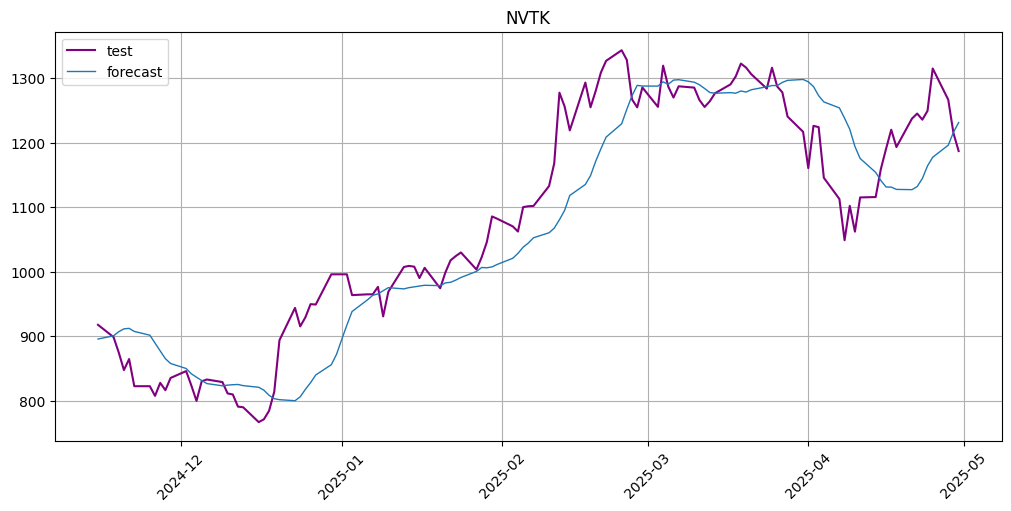

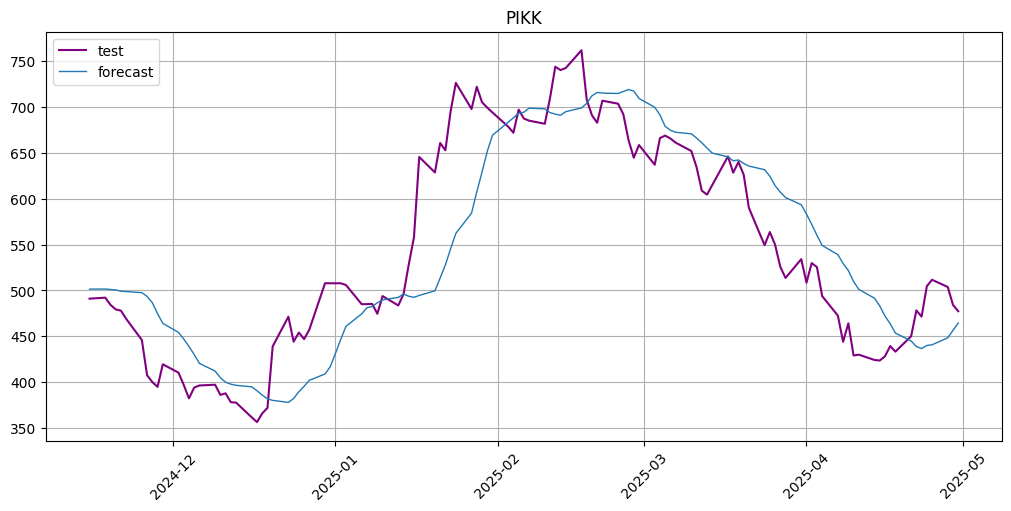

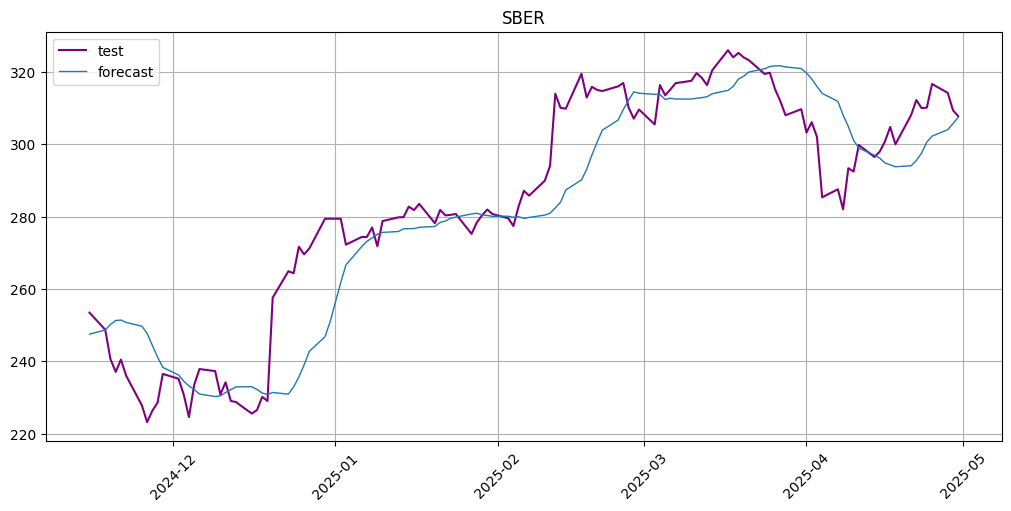

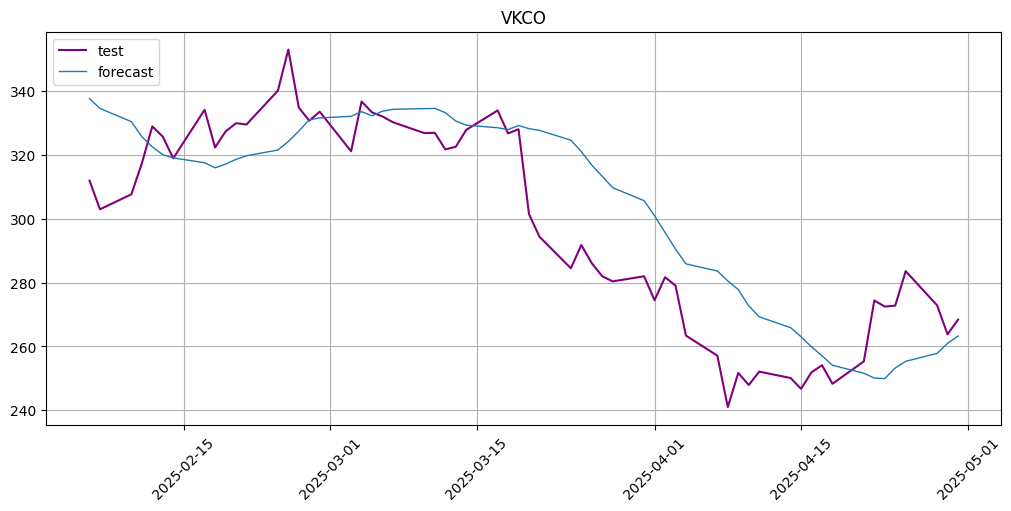

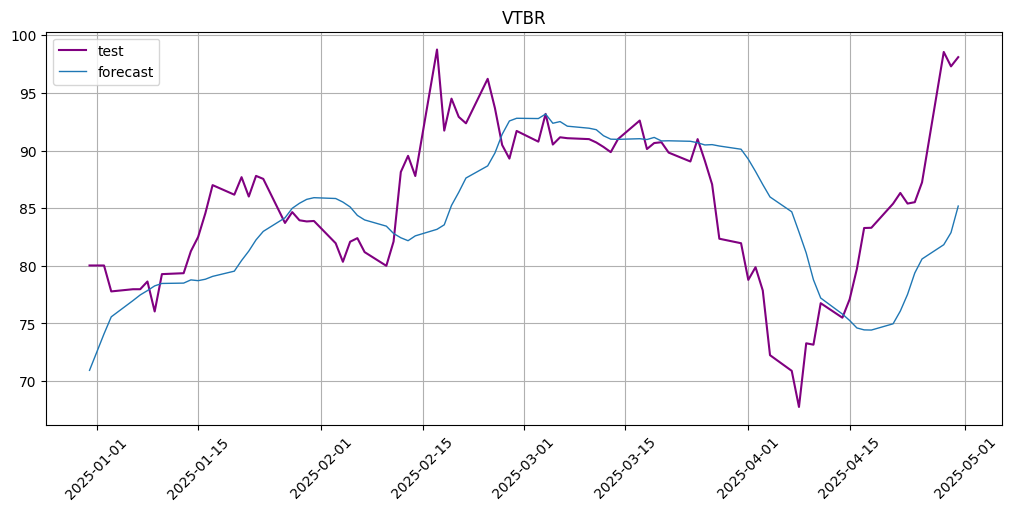

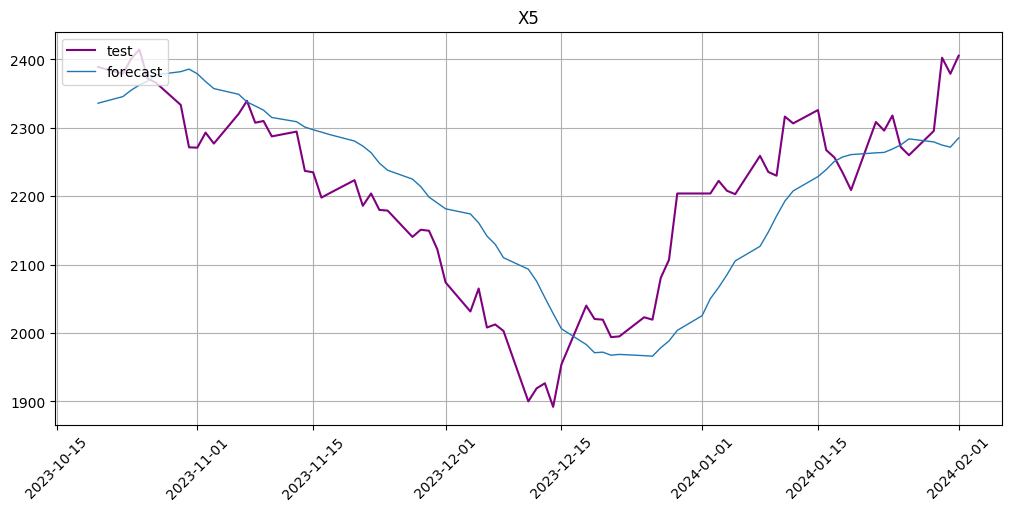

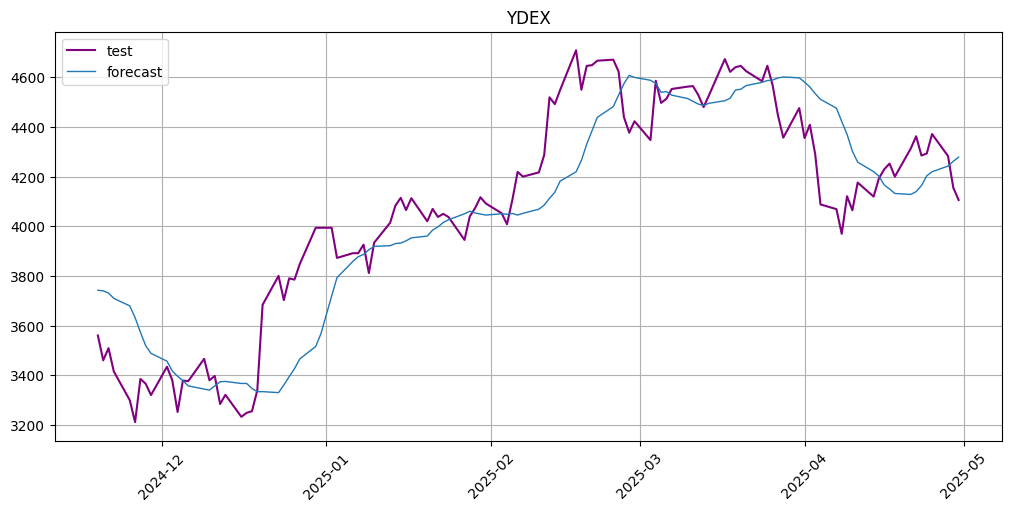

In [75]:
window_size = 10
results_map = {}

for ticker, (full_ts, train_ts, test_ts) in series.items():
    # 1) Инициализируем history_df из train_ts в «длинном» формате: timestamp, segment, target
    #    Берём только ту часть train_ts.df, которая относится к текущему ticker + feature="target"
    df_train_wide = train_ts.to_pandas(flatten=False)
    train_series = df_train_wide[(ticker, "target")]
    history_df = pd.DataFrame({
        "timestamp": train_series.index,
        "segment":   [ticker] * len(train_series),
        "target":    train_series.values
    })
    
    # 2) Получаем Series с фактическими тестовыми значениями (test_ts тоже MultiIndex)
    df_test_wide = test_ts.to_pandas(flatten=False)
    y_test = df_test_wide[(ticker, "target")]

    # 3) Walk-forward: на каждом шаге строим TSDataset из history_df, обучаем, предсказываем и добавляем строку
    preds = []
    times = []
    for idx in y_test.index:
        # 3.1) Собираем TSDataset с freq="B" из текущего history_df
        history_ts = TSDataset(df=history_df.copy(), freq="B")
        
        # 3.2) Обучаем SMA-модель на history_ts
        model = MovingAverageModel(window=window_size)
        start_time = time.time()
        model.fit(history_ts)

        # 3.3) Делаем прогноз на один шаг
        forecast_step = model.predict(ts=history_ts, prediction_size=1)
        end_time = time.time()
        times.append(end_time - start_time)  # Время в секундах
        
        # В forecast_step.df снова будет MultiIndex-колонка (ticker, "target"), берём последнее значение
        df_forecast_wide = forecast_step.to_pandas(flatten=False)
        p = df_forecast_wide[(ticker, "target")].iloc[-1]
        preds.append(p)

        # 3.4) Добавляем реальное значение в history_df
        real_value = y_test.loc[idx]
        df_real = pd.DataFrame({
            "timestamp": [idx],
            "segment":   [ticker],
            "target":    [real_value]
        })
        # Объединяем две плоские таблицы одинаковых колонок
        history_df = pd.concat([history_df, df_real], axis=0, ignore_index=True)

    # 4) Собираем "плоский" DataFrame с прогнозами на весь тестовый период
    forecast_df = pd.DataFrame({
        "timestamp": y_test.index.tolist(),
        "segment":   [ticker] * len(preds),
        "target":    preds
    })
    forecast_ts = TSDataset(df=forecast_df, freq=train_ts.freq)

    # 5) Считаем метрики через ETNA
    mae_v   = MAE()(test_ts,   forecast_ts)[ticker]
    mape_v  = MAPE()(test_ts,  forecast_ts)[ticker]
    rmse_v  = RMSE()(test_ts,  forecast_ts)[ticker]
    smape_v = SMAPE()(test_ts, forecast_ts)[ticker]
    da_v = directional_accuracy(y_test, np.array(preds))

    results_map[ticker] = {
        "MAE":       mae_v,
        "MAPE (%)":  mape_v,
        "RMSE":      rmse_v,
        "SMAPE (%)": smape_v,
        "DA (%)":    da_v,
        "Forecast time (s)": np.mean(np.array(times), axis=0)
    }

    plot_forecast(forecast_ts, test_ts)

In [76]:
# 7) Итоговая таблица метрик
metrics_df = pd.DataFrame.from_dict(results_map, orient="index")
metrics_df.loc["AVERAGE"] = metrics_df.mean(numeric_only=True)
metrics_df = metrics_df.round(3)
display(metrics_df)

MAE  MAPE (%)    RMSE  SMAPE (%)  DA (%)  Forecast time (s)
AFLT      3.161     5.065   3.986      5.078  51.695              0.003
LKOH    186.166     2.670 250.614      2.656  44.915              0.003
MOEX      8.330     4.075  10.381      4.088  48.305              0.003
NVTK     56.129     5.202  72.706      5.281  48.305              0.003
PIKK     46.032     8.719  58.209      8.769  52.542              0.003
SBER      9.748     3.470  13.362      3.517  47.458              0.003
VKCO     15.019     5.260  18.682      5.134  57.627              0.003
VTBR      4.810     5.702   6.387      5.756  55.814              0.003
X5       75.849     3.511  89.400      3.508  48.649              0.003
YDEX    157.080     3.911 204.274      3.936  52.586              0.003
AVERAGE  56.232     4.759  72.800      4.772  50.790              0.003

# Exponential Moving Average

In [77]:
class ExponentialMovingAverageModel(NonPredictionIntervalContextIgnorantAbstractModel):
    """
    Кастомная модель Exponential Moving Average:
      - При fit(train_ts) устанавливает alpha и вычисляет начальное EMA
      - При forecast(test_ts, prediction_size) использует walk-forward с обновлением EMA
    """

    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha
        self.initial_ema = None
        self._freq = None
        self.segment = None

    def fit(self, ts: TSDataset) -> None:
        """
        ts — это train-часть (одно-сегментный TSDataset).
        Вычисляем начальное EMA из обучающих данных.
        """
        self._freq = ts.freq
        df_flat = ts.to_pandas(flatten=True)
        self.segment = ts.segments[0]
        
        # Инициализируем EMA первым значением
        values = df_flat["target"].values
        ema = values[0]
        
        # Обновляем EMA по всей тренировочной выборке
        for i in range(1, len(values)):
            ema += self.alpha * (values[i] - ema)
        
        self.initial_ema = ema

    def forecast(self, ts: TSDataset, prediction_size: int) -> TSDataset:
        """
        ts — это test-часть (одно-сегментный TSDataset).
        Используем walk-forward прогнозирование с обновлением EMA.
        """
        df_test_flat = ts.to_pandas(flatten=True).reset_index()
        test_timestamps = df_test_flat["timestamp"].tolist()
        actual_test_values = df_test_flat["target"].values
        n_test = len(actual_test_values)

        preds = []
        current_ema = self.initial_ema

        for i in range(n_test):
            # Прогнозируем текущее значение EMA
            preds.append(current_ema)
            
            # Обновляем EMA реальным значением для следующего шага
            if i < n_test:
                current_ema += self.alpha * (actual_test_values[i] - current_ema)

        # Построим DataFrame прогноза
        df_forecast = pd.DataFrame({
            "timestamp": test_timestamps,
            "target": preds,
            "segment": self.segment
        })

        return TSDataset(df=df_forecast, freq=self._freq)

    def predict(self, ts: TSDataset, prediction_size: int) -> TSDataset:
        return self.forecast(ts, prediction_size)

    def get_model(self) -> str:
        return f"ExponentialMovingAverageModel(alpha={self.alpha})"


=== Итоговая таблица метрик EMA (alpha=0.1) ===


MAE  MAPE (%)    RMSE  SMAPE (%)  DA (%)  Forecast time (s)
AFLT      3.338     5.334   4.034      5.361  49.153              0.136
LKOH    166.099     2.387 230.936      2.368  44.068              0.102
MOEX      8.174     4.034   9.890      4.035  49.153              0.077
NVTK     61.195     5.688  75.074      5.782  52.542              0.082
PIKK     55.331    10.595  65.858     10.457  53.390              0.083
SBER     10.748     3.824  13.403      3.879  48.305              0.084
VKCO     14.951     5.364  19.408      5.152  40.678              0.145
VTBR      4.536     5.400   6.010      5.434  50.000              0.100
X5       82.465     3.810  97.491      3.793  47.297              0.113
YDEX    170.681     4.278 208.356      4.304  50.862              0.079
AVERAGE  57.752     5.071  73.046      5.056  48.545              0.100

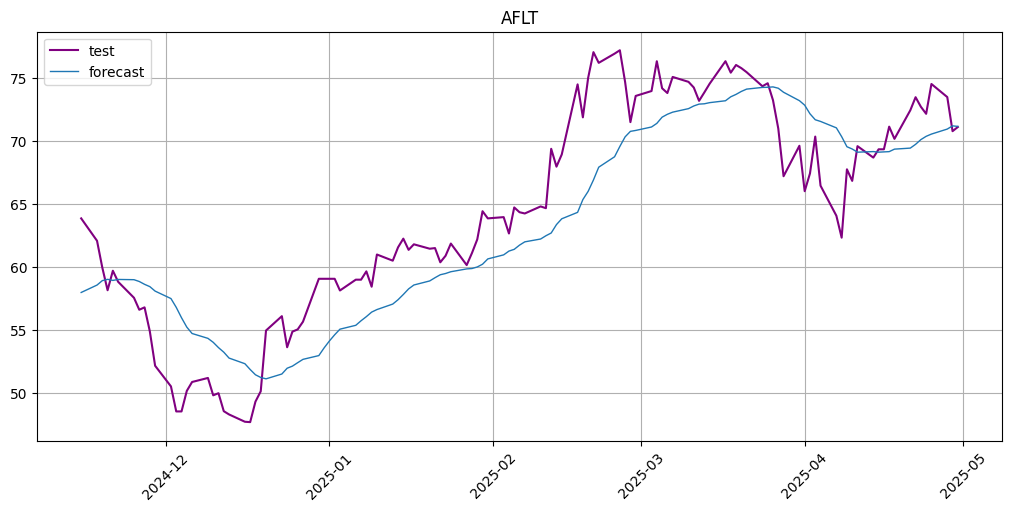

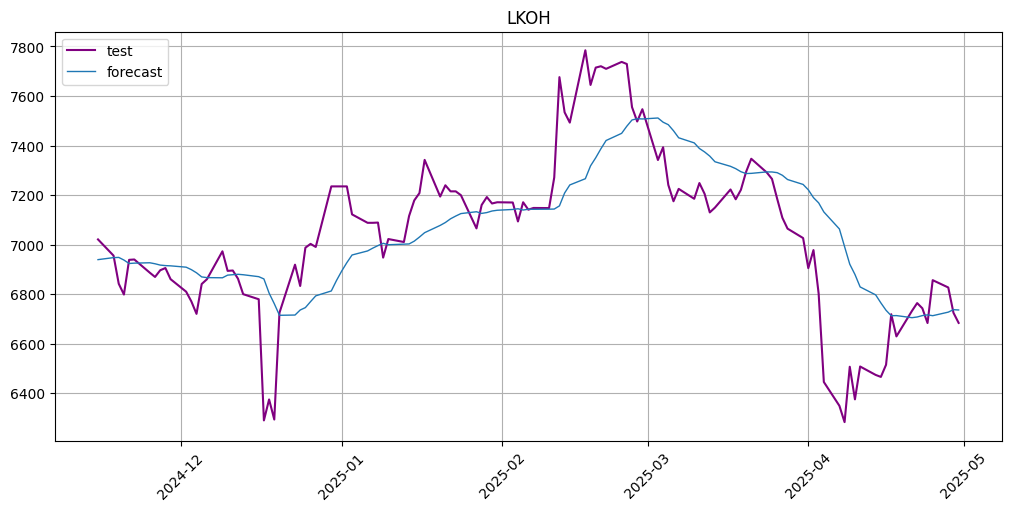

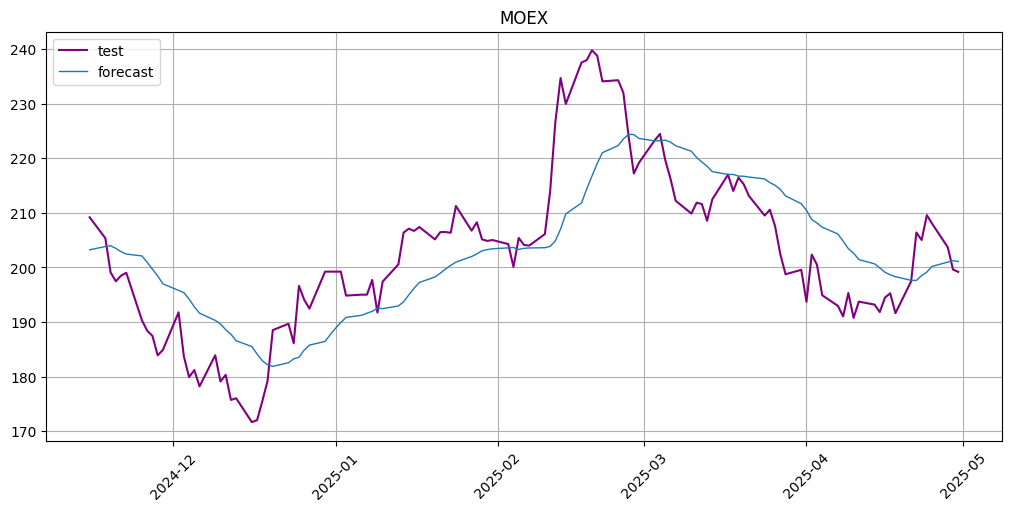

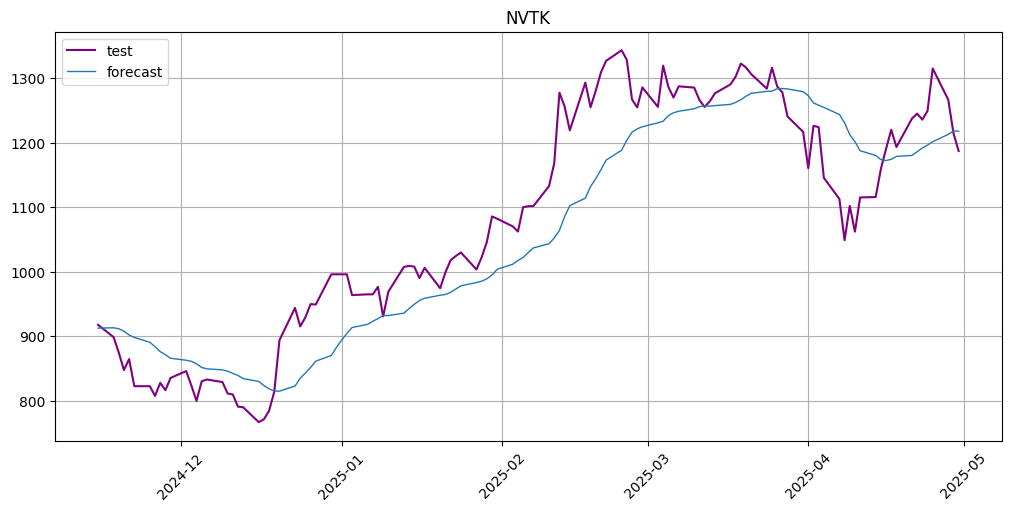

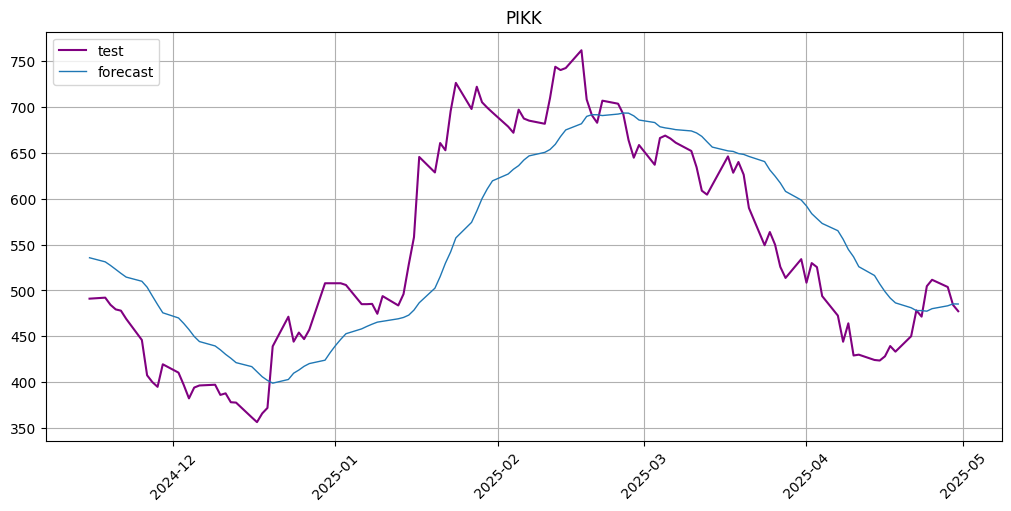

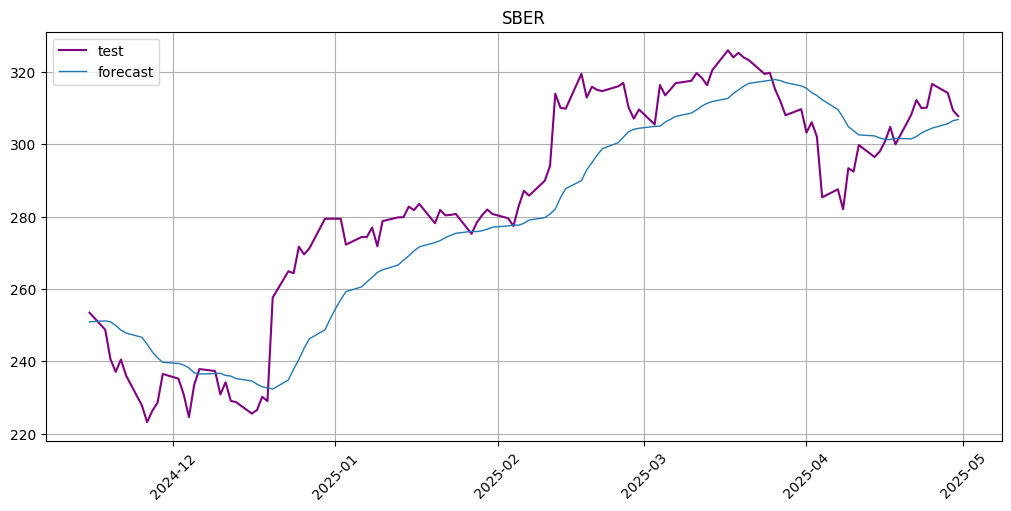

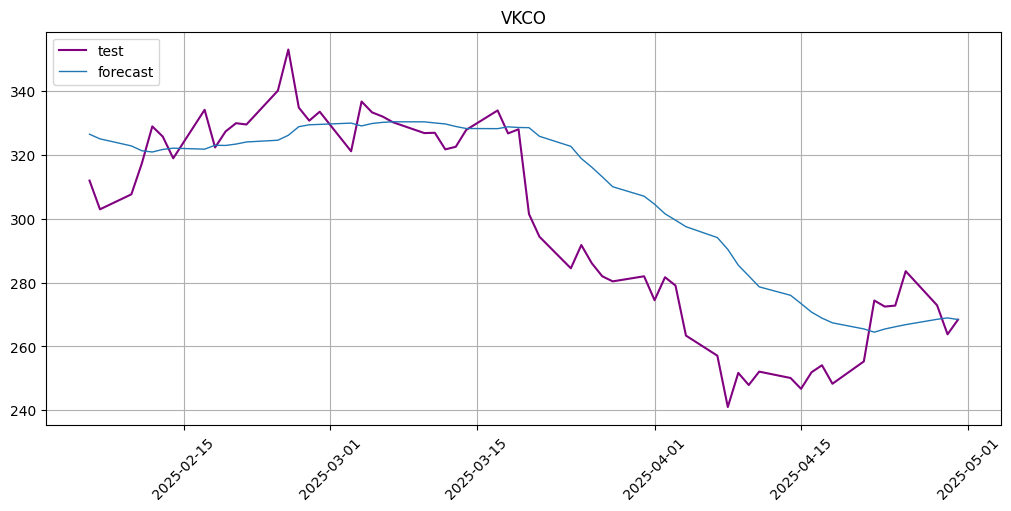

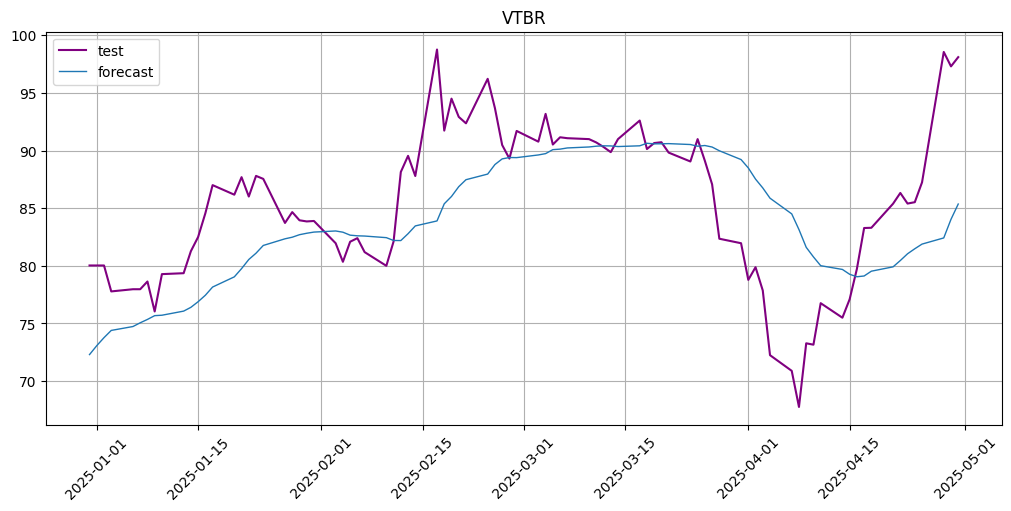

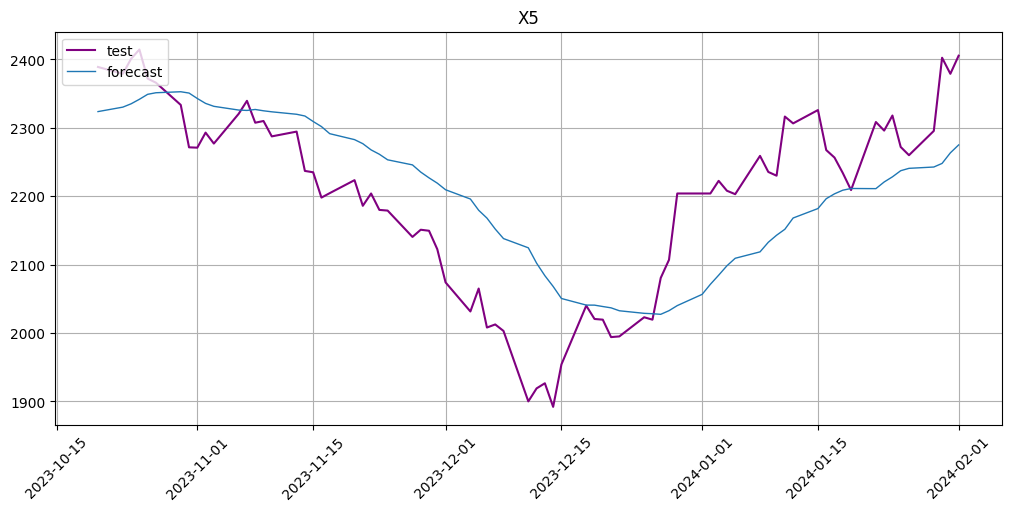

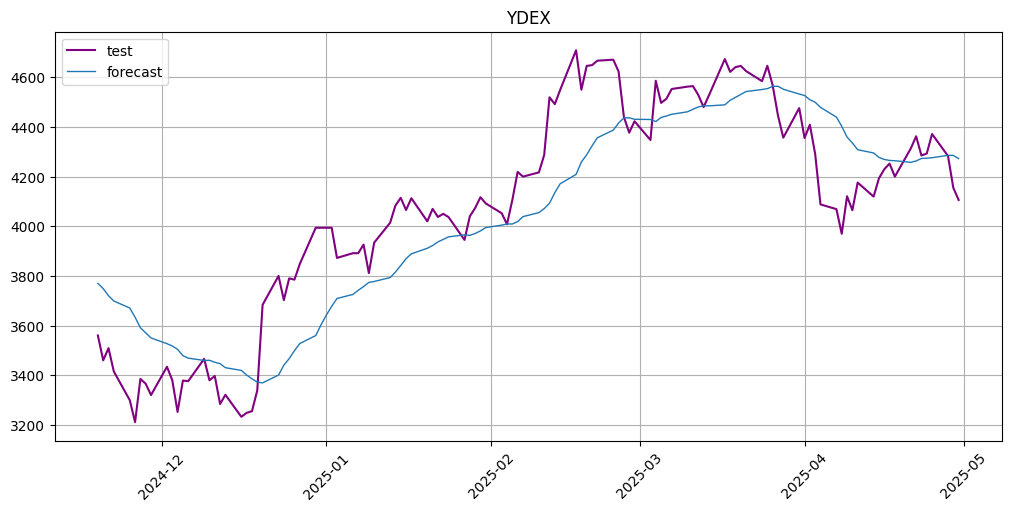

In [80]:
# Тестирование Exponential Moving Average
alpha = 0.1  # параметр сглаживания
results_map = {}

for ticker, (full_ts, train_ts, test_ts) in series.items():
    # 1) Инициализируем и обучаем EMA модель
    model = ExponentialMovingAverageModel(alpha=alpha)
    model.fit(train_ts)
    
    # 2) Выполняем прогноз на test_size точек и замеряем время
    df_test = test_ts.to_pandas(flatten=False)
    test_size = df_test.shape[0]

    start_time = time.time()
    forecast_ts = model.forecast(ts=test_ts, prediction_size=test_size)
    end_time = time.time()
    forecast_time = ((end_time - start_time) / test_size) * 1000  # Время в секундах на один прогноз
    
    # 3) Собираем прогноз и реальные значения в pandas.Series
    df_pred = forecast_ts.to_pandas(flatten=True)
    df_true = test_ts.to_pandas(flatten=True)
    
    y_true = df_true["target"].values
    y_pred = df_pred["target"].values

    # 4) Считаем метрики
    mae_v   = MAE()(test_ts, forecast_ts)
    mape_v  = MAPE()(test_ts, forecast_ts)
    rmse_v  = RMSE()(test_ts, forecast_ts)
    smape_v = SMAPE()(test_ts, forecast_ts)
    da_v = directional_accuracy(y_true, y_pred)
    
    # 5) Сохраняем метрики и прогноз
    results_map[ticker] = {
        "MAE": mae_v[ticker],
        "MAPE (%)": mape_v[ticker],
        "RMSE": rmse_v[ticker],
        "SMAPE (%)": smape_v[ticker],
        "DA (%)": da_v,
        "Forecast time (s)": forecast_time
    }
    
    plot_forecast(forecast_ts, test_ts)

# 6) Собираем сводную таблицу метрик
metrics_df = pd.DataFrame.from_dict(results_map, orient="index")
metrics_df.loc["AVERAGE"] = metrics_df.mean(numeric_only=True)
metrics_df = metrics_df.round(3)

print(f"\n=== Итоговая таблица метрик EMA (alpha={alpha}) ===")
display(metrics_df)

# Ensemble of Moving Averages

In [81]:
class EnsembleMovingAverageModel(NonPredictionIntervalContextIgnorantAbstractModel):
    """
    Ансамбль Exponential Moving Averages с разными периодами.
    Усредняет прогнозы EMA с разными alpha.
    """

    def __init__(self, periods=[5, 10, 20, 50]):
        super().__init__()
        self.periods = periods
        # Преобразуем периоды в alpha: alpha = 2/(period+1)
        self.alphas = {p: 2/(p+1) for p in periods}
        self.ema_models = {}
        self._freq = None
        self.segment = None

    def fit(self, ts: TSDataset) -> None:
        """
        Обучаем несколько EMA моделей с разными alpha.
        """
        self._freq = ts.freq
        self.segment = ts.segments[0]
        
        # Создаем и обучаем модель для каждого периода
        for period in self.periods:
            alpha = self.alphas[period]
            model = ExponentialMovingAverageModel(alpha=alpha)
            model.fit(ts)
            self.ema_models[period] = model

    def forecast(self, ts: TSDataset, prediction_size: int) -> TSDataset:
        """
        Получаем прогнозы от всех EMA моделей и усредняем их.
        """
        df_test_flat = ts.to_pandas(flatten=True).reset_index()
        test_timestamps = df_test_flat["timestamp"].tolist()
        
        # Собираем прогнозы от всех моделей
        all_predictions = []
        for period in self.periods:
            model = self.ema_models[period]
            forecast_ts = model.forecast(ts, prediction_size)
            df_pred = forecast_ts.to_pandas(flatten=True)
            predictions = df_pred["target"].values
            all_predictions.append(predictions)
        
        # Усредняем прогнозы
        ensemble_predictions = np.mean(all_predictions, axis=0)

        # Построим DataFrame прогноза
        df_forecast = pd.DataFrame({
            "timestamp": test_timestamps,
            "target": ensemble_predictions,
            "segment": self.segment
        })

        return TSDataset(df=df_forecast, freq=self._freq)

    def predict(self, ts: TSDataset, prediction_size: int) -> TSDataset:
        return self.forecast(ts, prediction_size)

    def get_model(self) -> str:
        return f"EnsembleMovingAverageModel(periods={self.periods})"


=== Итоговая таблица метрик Ensemble MA (periods=[5, 10, 20, 50]) ===


MAE  MAPE (%)    RMSE  SMAPE (%)  DA (%)  Forecast time (s)
AFLT      2.984     4.707   3.589      4.749  47.458              0.001
LKOH    147.623     2.121 205.562      2.108  47.458              0.000
MOEX      7.006     3.460   8.673      3.458  48.305              0.000
NVTK     57.057     5.281  68.306      5.363  51.695              0.000
PIKK     48.056     9.304  58.107      9.119  52.542              0.000
SBER      9.952     3.542  12.138      3.586  48.305              0.000
VKCO     13.315     4.761  17.117      4.602  40.678              0.001
VTBR      3.862     4.566   5.174      4.599  50.000              0.001
X5       68.929     3.189  82.409      3.174  47.297              0.001
YDEX    154.656     3.867 186.426      3.888  51.724              0.000
AVERAGE  51.344     4.480  64.750      4.465  48.546              0.001

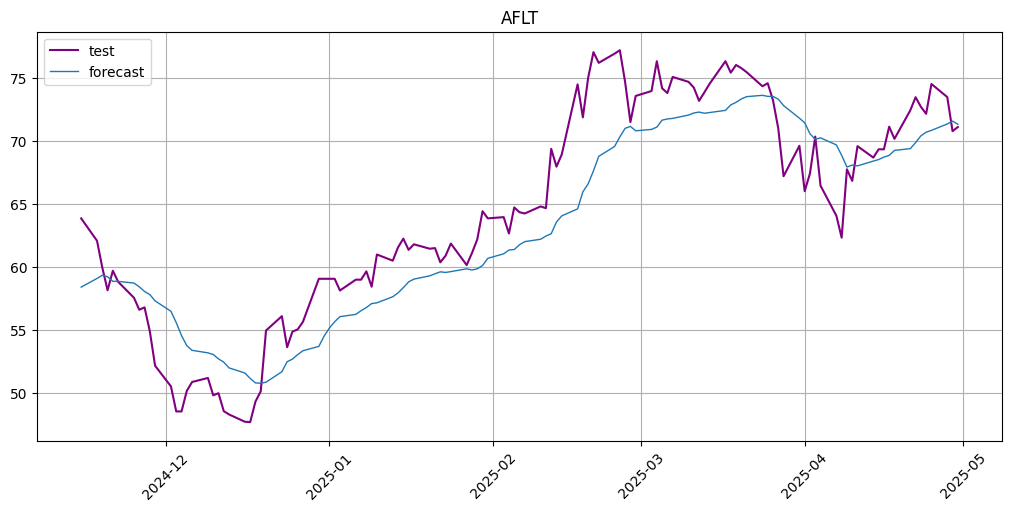

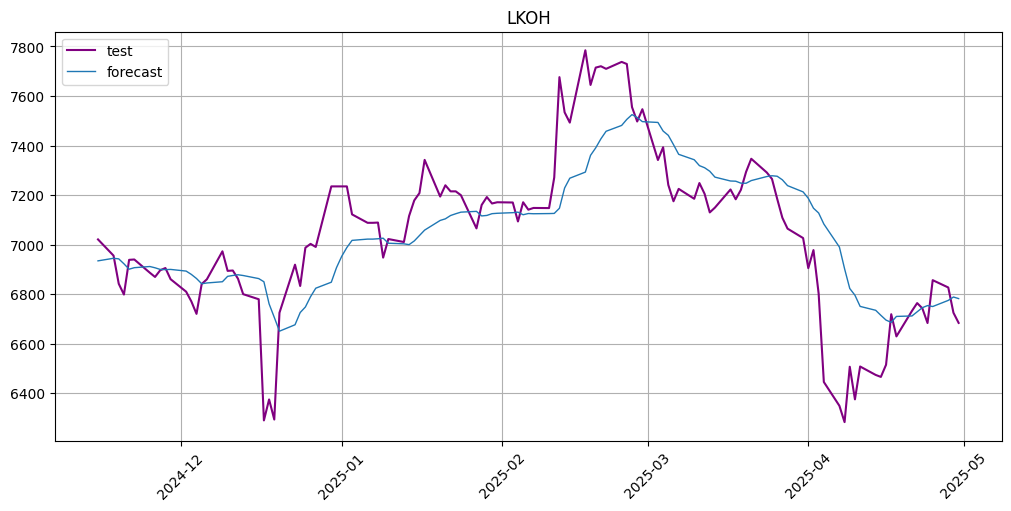

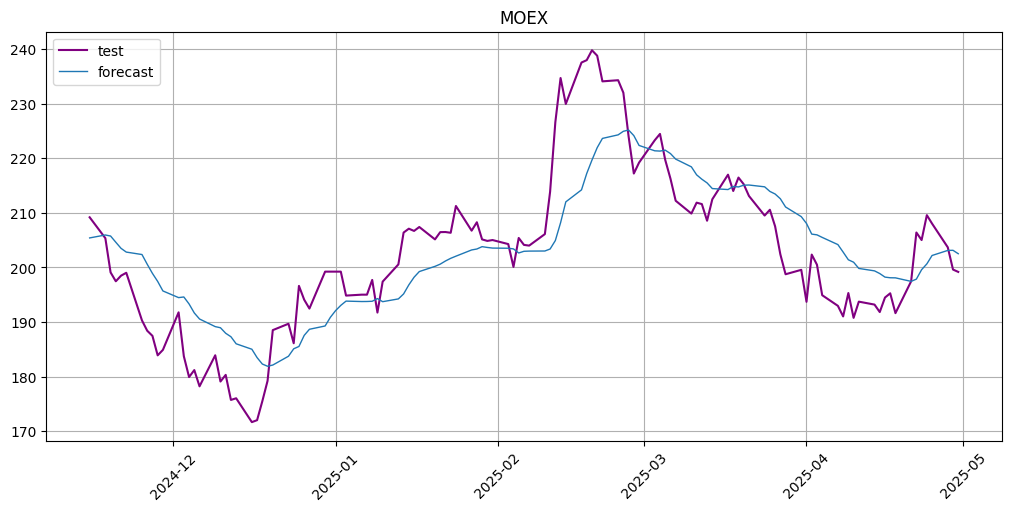

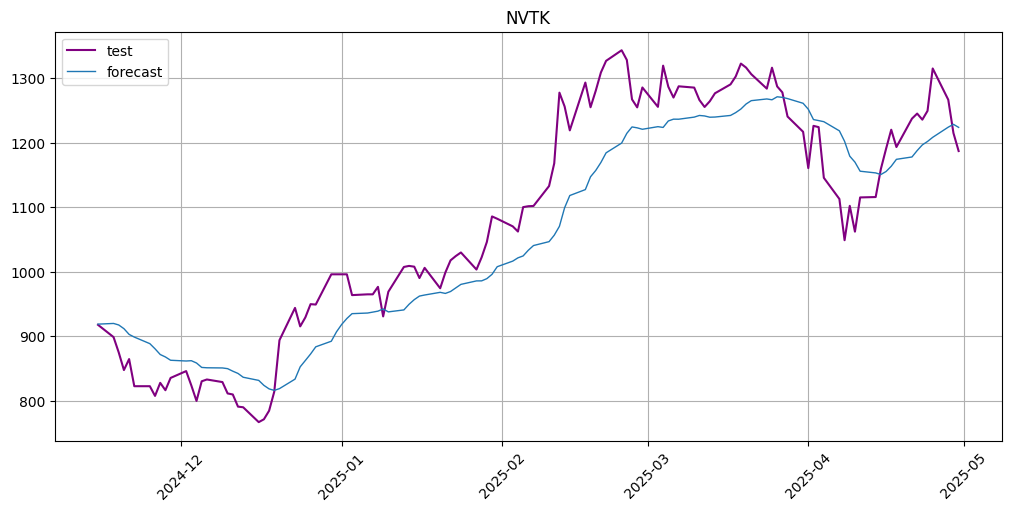

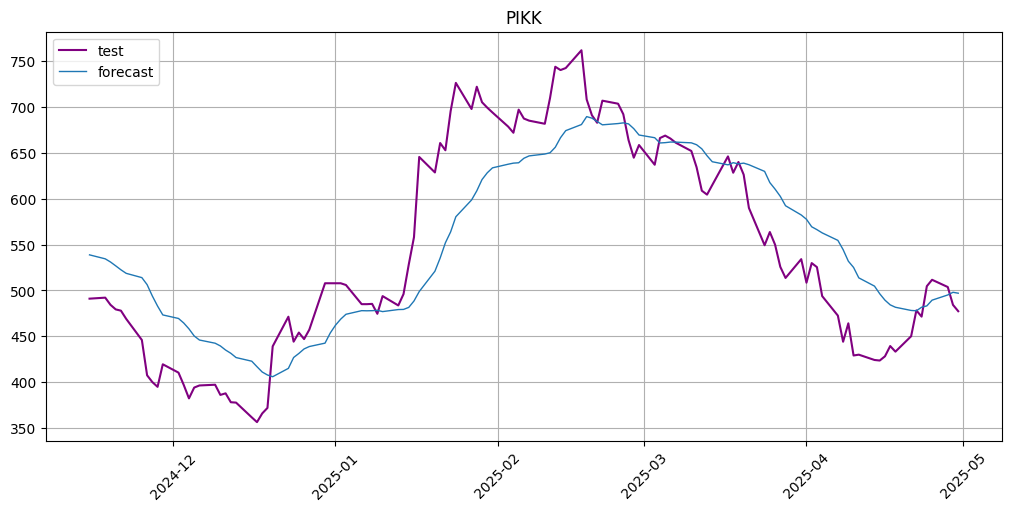

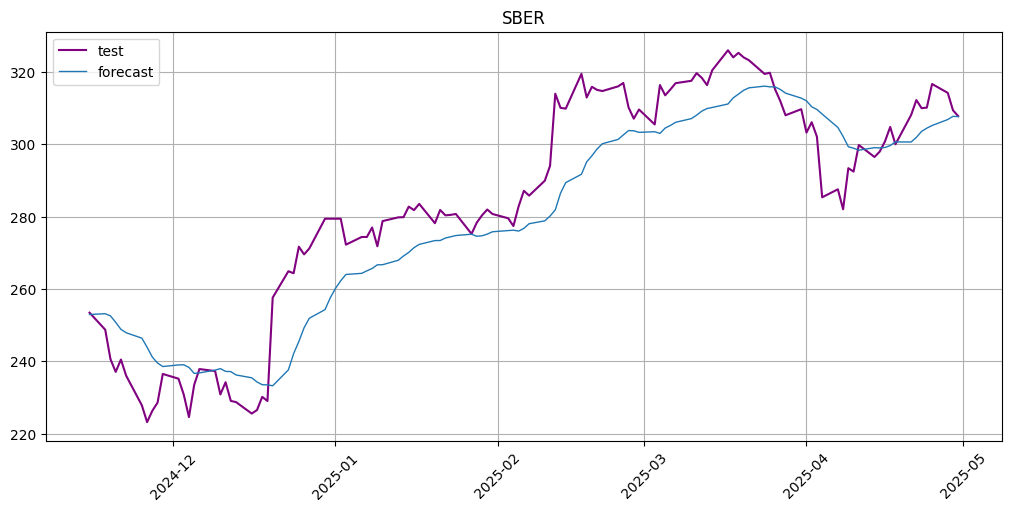

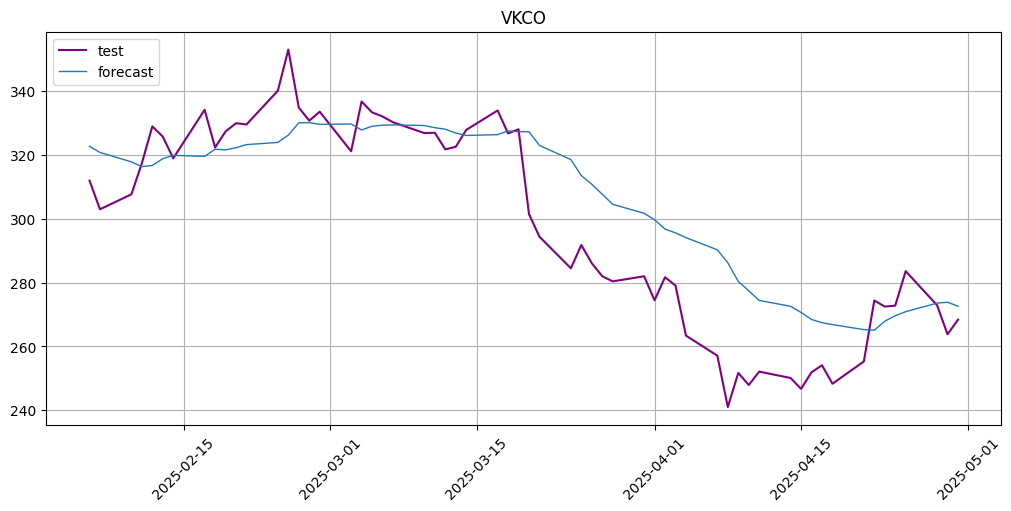

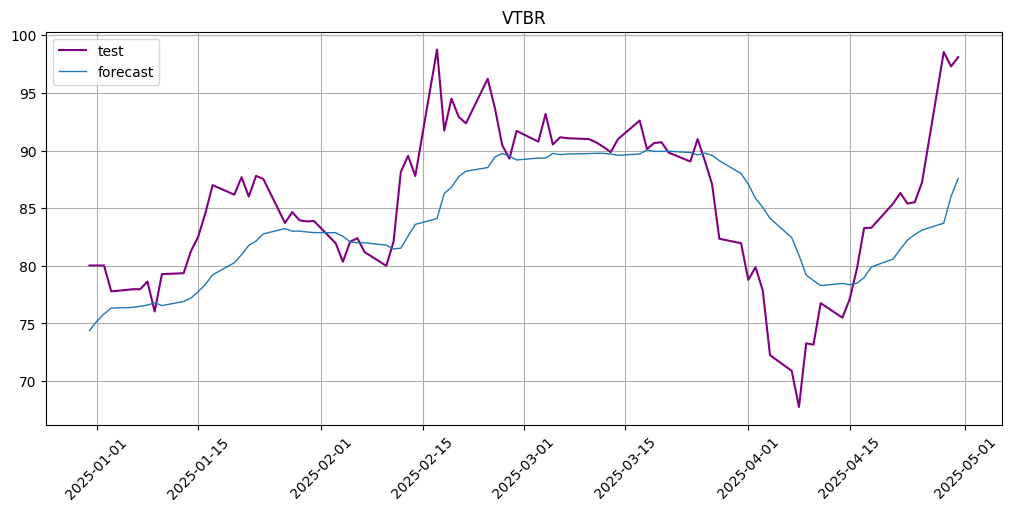

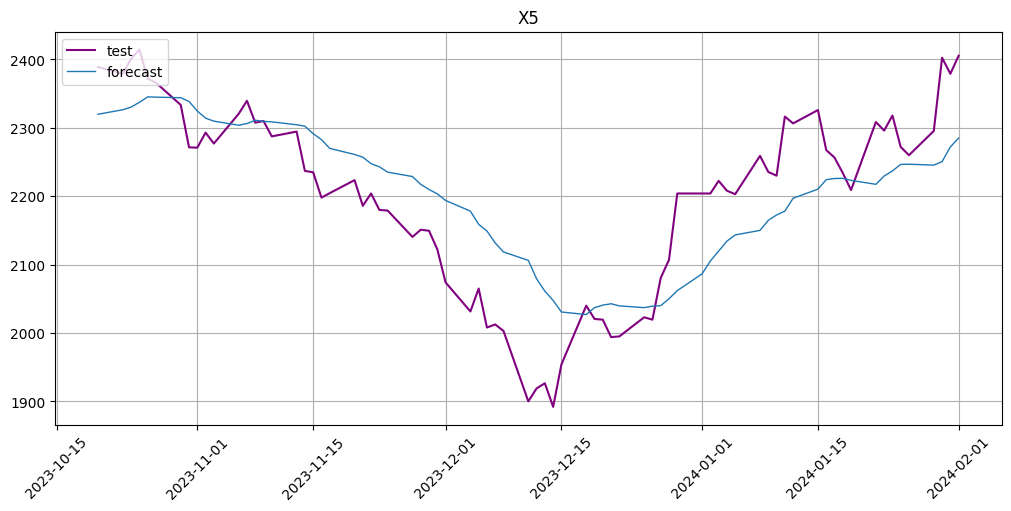

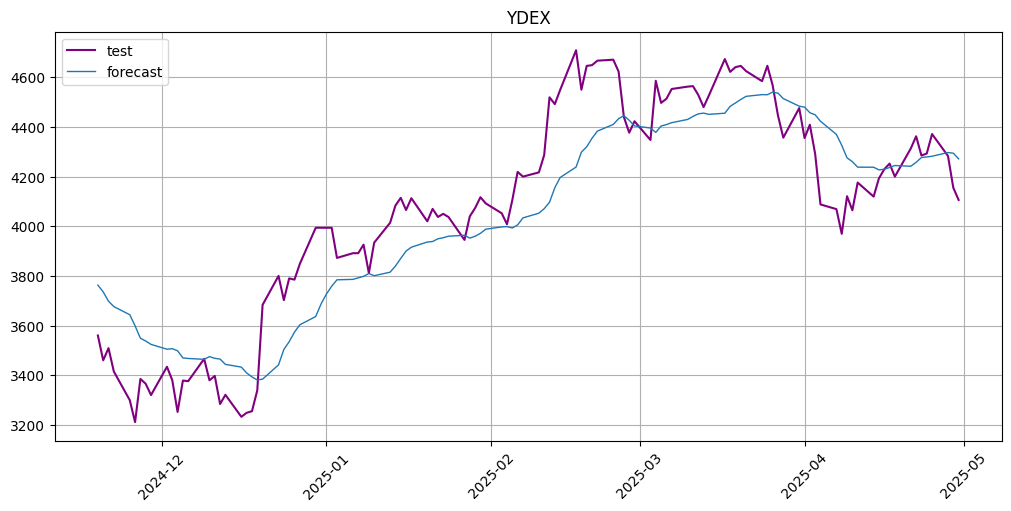

In [82]:
# Тестирование Ensemble of Moving Averages
periods = [5, 10, 20, 50]  # периоды для ансамбля
results_map = {}

for ticker, (full_ts, train_ts, test_ts) in series.items():
    # 1) Инициализируем и обучаем Ensemble модель
    model = EnsembleMovingAverageModel(periods=periods)
    model.fit(train_ts)
    
    # 2) Выполняем прогноз на test_size точек и замеряем время
    df_test = test_ts.to_pandas(flatten=False)
    test_size = df_test.shape[0]

    start_time = time.time()
    forecast_ts = model.forecast(ts=test_ts, prediction_size=test_size)
    end_time = time.time()
    forecast_time = ((end_time - start_time) / test_size)  # Время в секундах на один прогноз
    
    # 3) Собираем прогноз и реальные значения в pandas.Series
    df_pred = forecast_ts.to_pandas(flatten=True)
    df_true = test_ts.to_pandas(flatten=True)
    
    y_true = df_true["target"].values
    y_pred = df_pred["target"].values

    # 4) Считаем метрики
    mae_v   = MAE()(test_ts, forecast_ts)
    mape_v  = MAPE()(test_ts, forecast_ts)
    rmse_v  = RMSE()(test_ts, forecast_ts)
    smape_v = SMAPE()(test_ts, forecast_ts)
    da_v = directional_accuracy(y_true, y_pred)
    
    # 5) Сохраняем метрики и прогноз
    results_map[ticker] = {
        "MAE": mae_v[ticker],
        "MAPE (%)": mape_v[ticker],
        "RMSE": rmse_v[ticker],
        "SMAPE (%)": smape_v[ticker],
        "DA (%)": da_v,
        "Forecast time (s)": forecast_time
    }
    
    plot_forecast(forecast_ts, test_ts)

# 6) Собираем сводную таблицу метрик
metrics_df = pd.DataFrame.from_dict(results_map, orient="index")
metrics_df.loc["AVERAGE"] = metrics_df.mean(numeric_only=True)
metrics_df = metrics_df.round(3)

print(f"\n=== Итоговая таблица метрик Ensemble MA (periods={periods}) ===")
display(metrics_df)

# Drift Method

In [83]:
class DriftModel(NonPredictionIntervalContextIgnorantAbstractModel):
    """
    Метод Drift (Random Walk with Drift):
    Прогнозирует следующее значение как: последнее_значение + средний_дрифт
    где средний_дрифт = (последнее_значение - первое_значение) / (количество_периодов - 1)
    """

    def __init__(self):
        super().__init__()
        self.last_train_value = None
        self.drift_per_step = None
        self._freq = None
        self.segment = None

    def fit(self, ts: TSDataset) -> None:
        """
        ts — это train-часть (одно-сегментный TSDataset).
        Вычисляем дрифт по обучающим данным.
        """
        self._freq = ts.freq
        df_flat = ts.to_pandas(flatten=True)
        self.segment = ts.segments[0]
        
        values = df_flat["target"].values
        self.last_train_value = values[-1]
        
        # Вычисляем средний дрифт за шаг
        if len(values) > 1:
            self.drift_per_step = (values[-1] - values[0]) / (len(values) - 1)
        else:
            self.drift_per_step = 0.0

    def forecast(self, ts: TSDataset, prediction_size: int) -> TSDataset:
        """
        ts — это test-часть (одно-сегментный TSDataset).
        Используем walk-forward прогнозирование с обновлением дрифта.
        """
        df_test_flat = ts.to_pandas(flatten=True).reset_index()
        test_timestamps = df_test_flat["timestamp"].tolist()
        actual_test_values = df_test_flat["target"].values
        n_test = len(actual_test_values)

        preds = []
        current_value = self.last_train_value

        for i in range(n_test):
            # Прогнозируем следующее значение как current_value + drift
            next_pred = current_value + self.drift_per_step
            preds.append(next_pred)
            
            # Для следующего шага используем реальное значение
            if i < n_test:
                current_value = actual_test_values[i]
                # Обновляем дрифт на основе нового наблюдения
                # (простое скользящее окно для обновления дрифта не реализуем, используем фиксированный)

        # Построим DataFrame прогноза
        df_forecast = pd.DataFrame({
            "timestamp": test_timestamps,
            "target": preds,
            "segment": self.segment
        })

        return TSDataset(df=df_forecast, freq=self._freq)

    def predict(self, ts: TSDataset, prediction_size: int) -> TSDataset:
        return self.forecast(ts, prediction_size)

    def get_model(self) -> str:
        return f"DriftModel(drift_per_step={self.drift_per_step:.6f})"


=== Итоговая таблица метрик Drift Method ===


MAE  MAPE (%)    RMSE  SMAPE (%)  DA (%)  Forecast time (s)
AFLT     1.374     2.134   1.802      2.141  38.983              0.172
LKOH    81.379     1.168 118.375      1.168  41.525              0.081
MOEX     3.250     1.608   4.162      1.610  42.373              0.080
NVTK    24.810     2.286  31.921      2.294  52.542              0.088
PIKK    16.133     2.988  21.561      3.003  49.153              0.091
SBER     3.873     1.396   5.499      1.403  40.678              0.080
VKCO     6.855     2.318   8.742      2.319  40.678              0.146
VTBR     1.888     2.204   2.774      2.220  44.186              0.097
X5      28.786     1.318  38.885      1.321  40.541              0.112
YDEX    71.759     1.793  91.423      1.798  40.517              0.078
AVERAGE 24.011     1.921  32.514      1.928  43.118              0.102

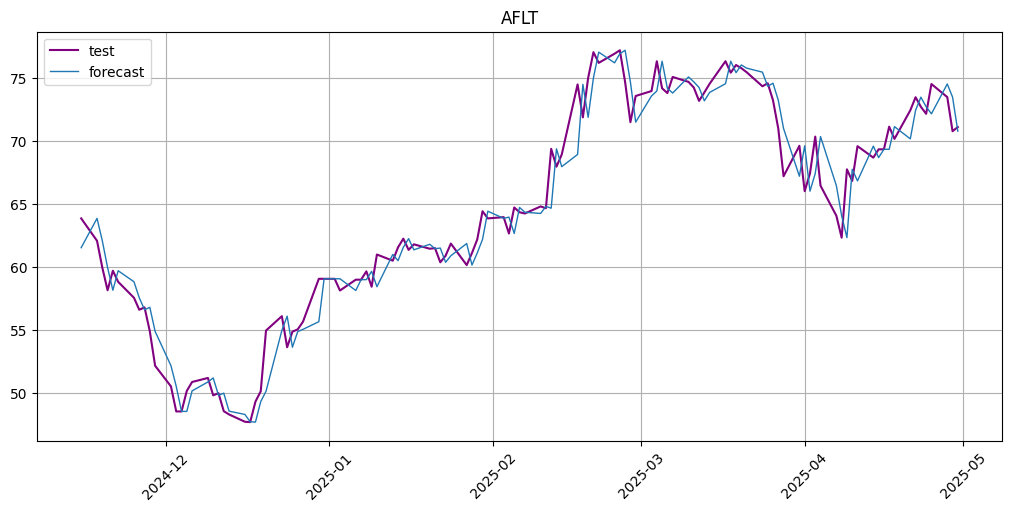

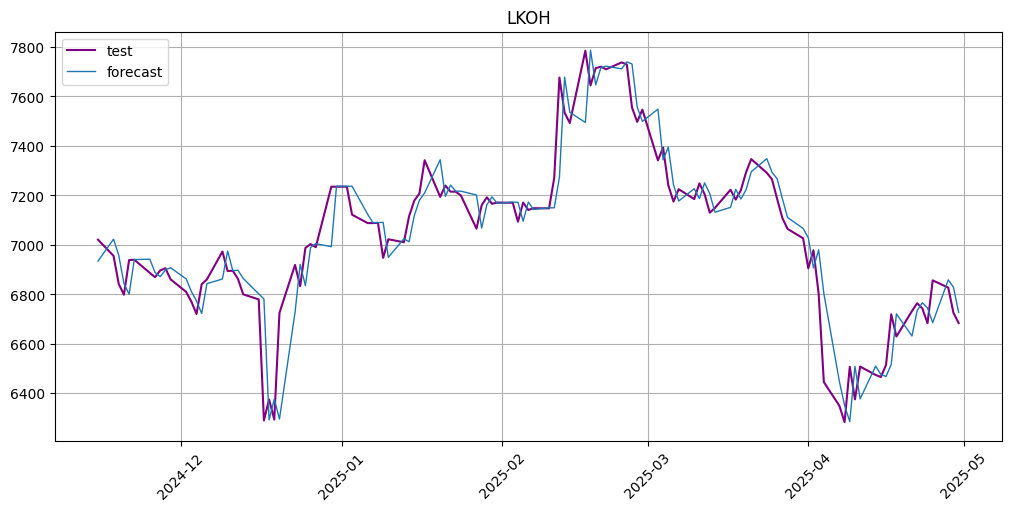

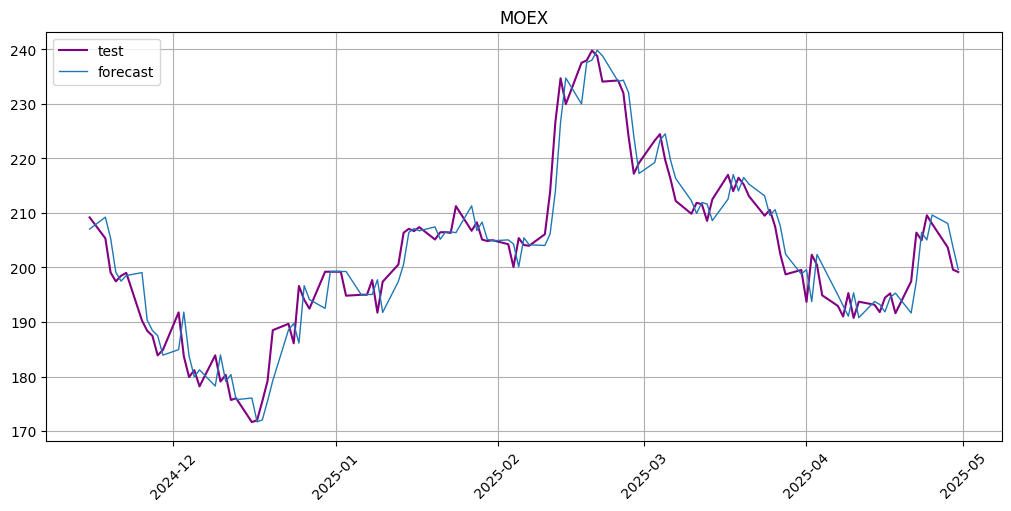

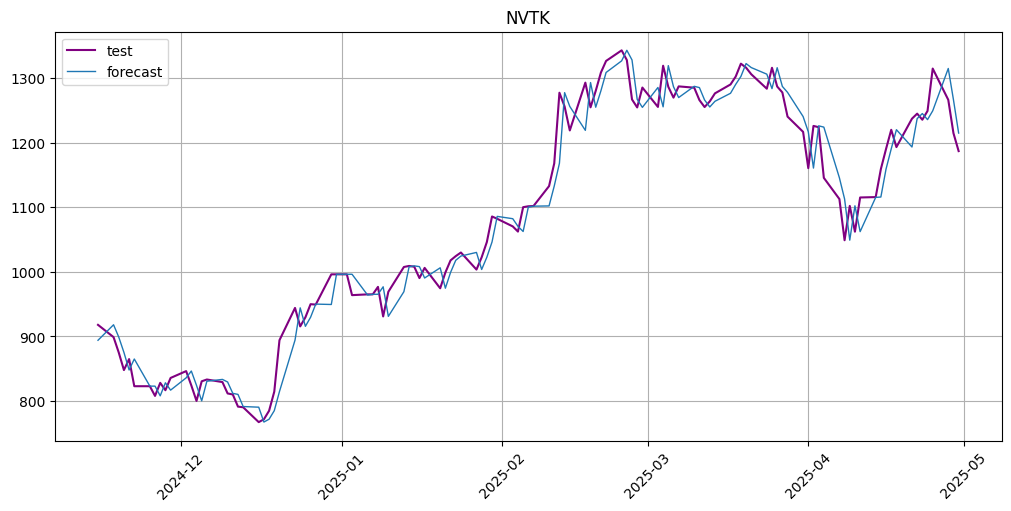

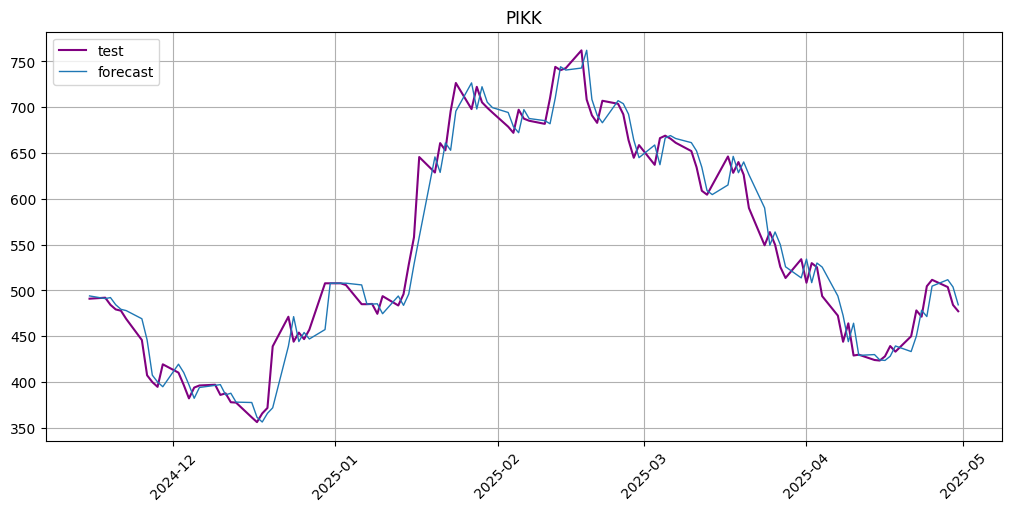

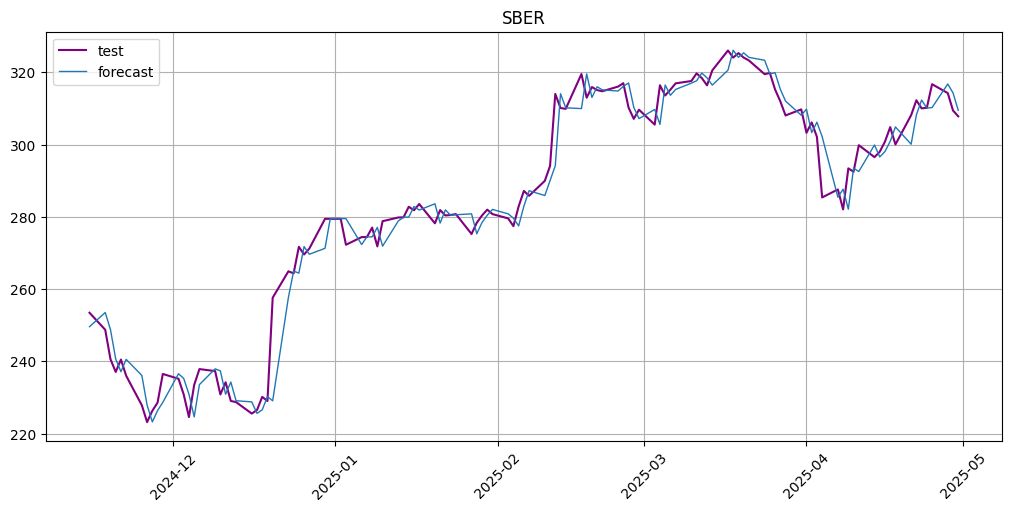

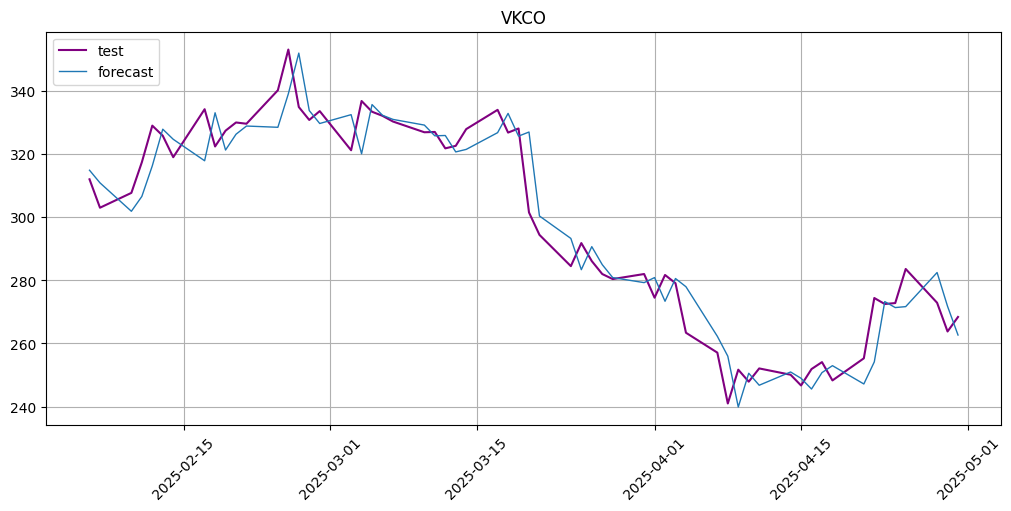

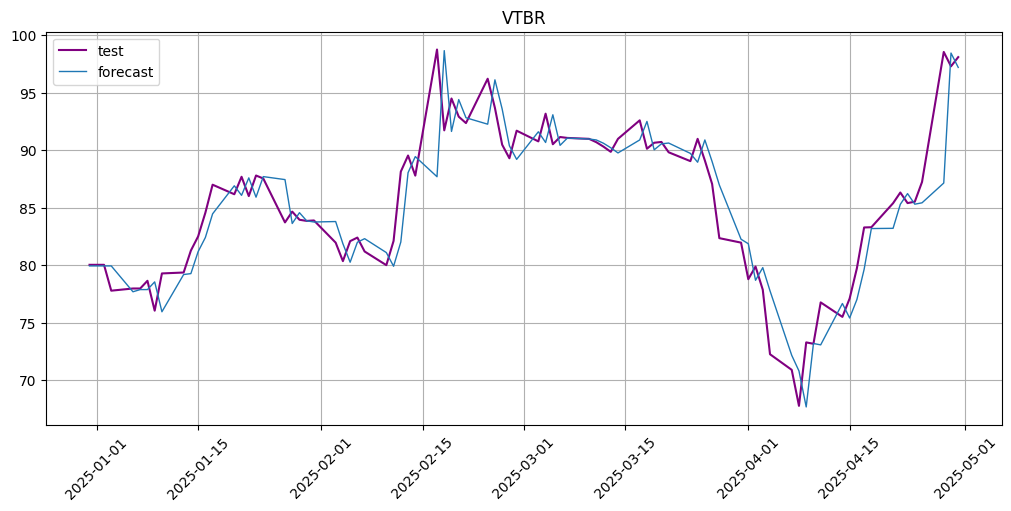

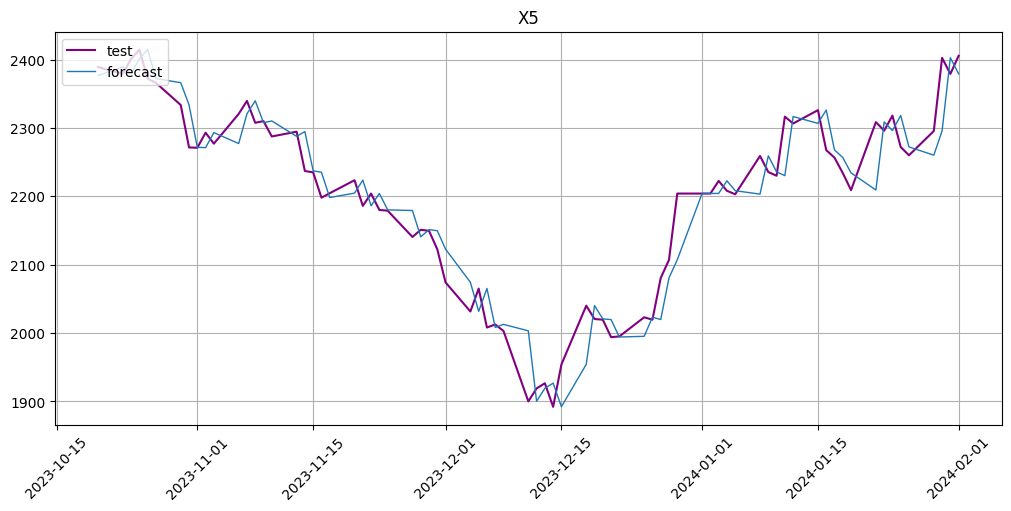

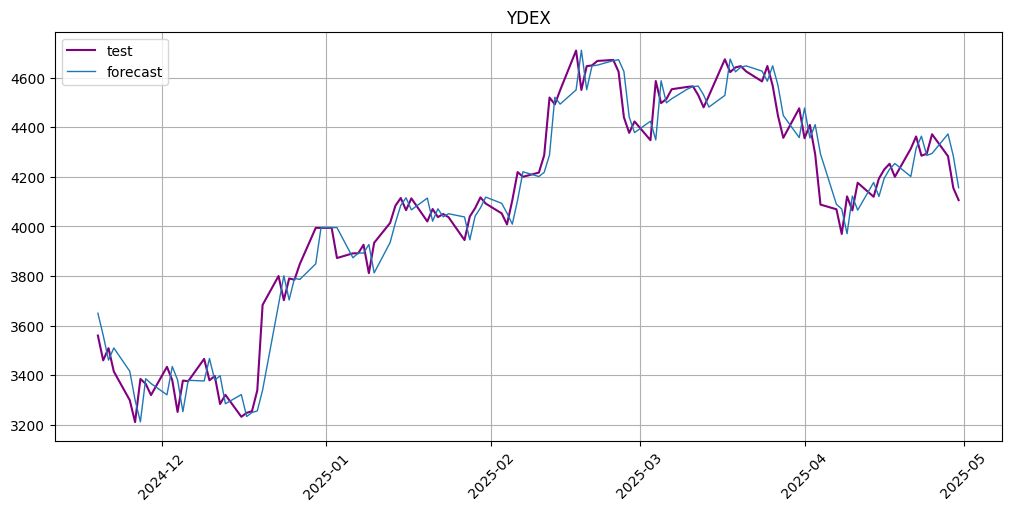

In [85]:
# Тестирование Drift Method
results_map = {}

for ticker, (full_ts, train_ts, test_ts) in series.items():
    # 1) Инициализируем и обучаем Drift модель
    model = DriftModel()
    model.fit(train_ts)
    
    # 2) Выполняем прогноз на test_size точек и замеряем время
    df_test = test_ts.to_pandas(flatten=False)
    test_size = df_test.shape[0]
    
    start_time = time.time()
    forecast_ts = model.forecast(ts=test_ts, prediction_size=test_size)
    end_time = time.time()
    forecast_time = ((end_time - start_time) / test_size) * 1000  # Время в секундах на один прогноз
    
    # 3) Собираем прогноз и реальные значения в pandas.Series
    df_pred = forecast_ts.to_pandas(flatten=True)
    df_true = test_ts.to_pandas(flatten=True)
    
    y_true = df_true["target"].values
    y_pred = df_pred["target"].values

    # 4) Считаем метрики
    mae_v   = MAE()(test_ts, forecast_ts)
    mape_v  = MAPE()(test_ts, forecast_ts)
    rmse_v  = RMSE()(test_ts, forecast_ts)
    smape_v = SMAPE()(test_ts, forecast_ts)
    da_v = directional_accuracy(y_true, y_pred)
    
    # 5) Сохраняем метрики и прогноз
    results_map[ticker] = {
        "MAE": mae_v[ticker],
        "MAPE (%)": mape_v[ticker],
        "RMSE": rmse_v[ticker],
        "SMAPE (%)": smape_v[ticker],
        "DA (%)": da_v,
        "Forecast time (s)": forecast_time
    }
    
    plot_forecast(forecast_ts, test_ts)

# 6) Собираем сводную таблицу метрик
metrics_df = pd.DataFrame.from_dict(results_map, orient="index")
metrics_df.loc["AVERAGE"] = metrics_df.mean(numeric_only=True)
metrics_df = metrics_df.round(3)

print("\n=== Итоговая таблица метрик Drift Method ===")
display(metrics_df)

# Статистические модели

## ARIMA (etna.models.StatsForecastARIMAModel)

## AutoArima

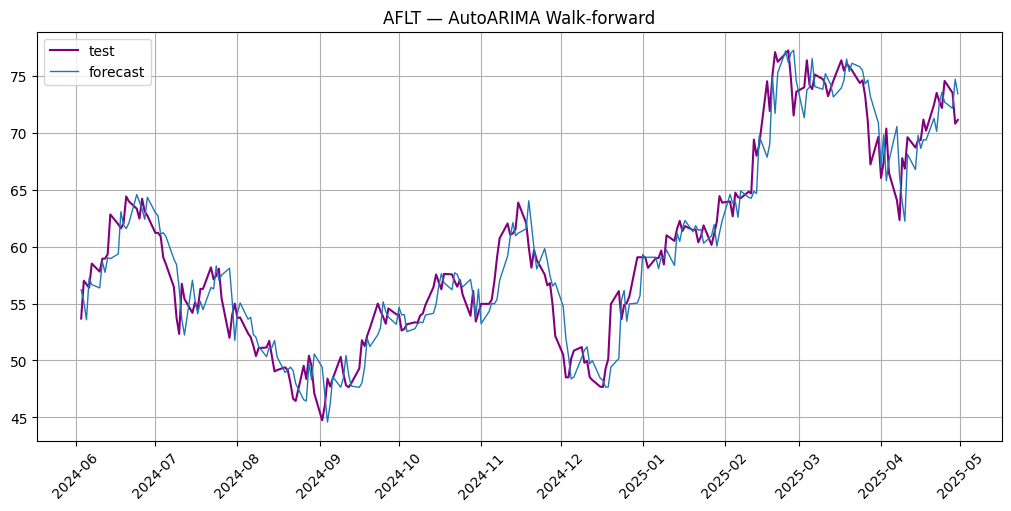

KeyboardInterrupt: 

In [50]:
results_map = {}

for ticker, (full_ts, train_ts, test_ts) in series.items():
    # 1) Собираем history_df из train_ts
    #    Получаем широкую таблицу и вынимаем нужную серию
    df_train_wide = train_ts.to_pandas(flatten=False)
    train_series = df_train_wide[(ticker, "target")]
    history_df = pd.DataFrame({
        "timestamp": train_series.index,
        "segment":   [ticker] * len(train_series),
        "target":    train_series.values
    })

    # 2) Готовим реальные значения теста
    df_test_wide = test_ts.to_pandas(flatten=False)
    y_test = df_test_wide[(ticker, "target")]

    preds = []
    times = []

    # 3) Walk-forward итерации по каждому таймстемпу в тесте
    for idx in y_test.index:
        # 3.1) Формируем TSDataset из накопленного history_df
        history_ts = TSDataset(df=history_df.copy(), freq=train_ts.freq)

        # 3.2) Инициализируем AutoARIMA и меряем время fit+forecast на 1 шаг
        model = AutoARIMAModel()
        t0 = time.time()
        model.fit(history_ts)
        forecast_step = model.predict(ts=history_ts)
        t1 = time.time()
        times.append(t1 - t0)

        # 3.3) Забираем предсказание последнего ряда
        df_forecast_wide = forecast_step.to_pandas(flatten=False)
        p = df_forecast_wide[(ticker, "target")].iloc[-1]
        preds.append(p)

        # 3.4) Добавляем в history_df реальное значение для следующего шага
        history_df = pd.concat([
            history_df,
            pd.DataFrame({
                "timestamp": [idx],
                "segment":   [ticker],
                "target":    [y_test.loc[idx]]
            })
        ], ignore_index=True)

    # 4) Собираем TSDataset из всех предсказаний
    forecast_df = pd.DataFrame({
        "timestamp": y_test.index.tolist(),
        "segment":   [ticker] * len(preds),
        "target":    preds
    })
    forecast_ts = TSDataset(df=forecast_df, freq=train_ts.freq)

    # 5) Считаем метрики
    mae_v   = MAE()(test_ts,   forecast_ts)[ticker]
    mape_v  = MAPE()(test_ts,  forecast_ts)[ticker]
    rmse_v  = RMSE()(test_ts,  forecast_ts)[ticker]
    smape_v = SMAPE()(test_ts, forecast_ts)[ticker]
    da_v    = directional_accuracy(y_test.values, np.array(preds))

    results_map[ticker] = {
        "MAE":       mae_v,
        "MAPE (%)":  mape_v,
        "RMSE":      rmse_v,
        "SMAPE (%)": smape_v,
        "DA (%)":    da_v,
        "Forecast time (s)": np.mean(times)
    }

    # 6) Визуализация
    plot_forecast(forecast_ts, test_ts)
    plt.title(f"{ticker} — AutoARIMA Walk-forward")
    plt.show()

# 7) Сводная таблица
metrics_df = pd.DataFrame.from_dict(results_map, orient="index")
metrics_df.loc["AVERAGE"] = metrics_df.mean(numeric_only=True)
metrics_df = metrics_df.round(3)

print("\n=== Итоговая таблица метрик AutoARIMA ===")
display(metrics_df)

## TBATS

In [ ]:
results_map = {}

for ticker, (full_ts, train_ts, test_ts) in series.items():
    # 1) Собираем history_df из train_ts
    #    Получаем широкую таблицу и вынимаем нужную серию
    df_train_wide = train_ts.to_pandas(flatten=False)
    train_series = df_train_wide[(ticker, "target")]
    history_df = pd.DataFrame({
        "timestamp": train_series.index,
        "segment":   [ticker] * len(train_series),
        "target":    train_series.values
    })

    # 2) Готовим реальные значения теста
    df_test_wide = test_ts.to_pandas(flatten=False)
    y_test = df_test_wide[(ticker, "target")]

    preds = []
    times = []

    # 3) Walk-forward итерации по каждому таймстемпу в тесте
    for idx in y_test.index:
        # 3.1) Формируем TSDataset из накопленного history_df
        history_ts = TSDataset(df=history_df.copy(), freq=train_ts.freq)

        # 3.2) Инициализируем AutoARIMA и меряем время fit+forecast на 1 шаг
        model = TBATSModel(
              use_box_cox=True,
              box_cox_bounds=(0, 1),
              use_trend=True,
              use_damped_trend=False,
              seasonal_periods=[],
              use_arma_errors=False,
        )
        t0 = time.time()
        model.fit(history_ts)
        forecast_step = model.predict(ts=history_ts)
        t1 = time.time()
        times.append(t1 - t0)

        # 3.3) Забираем предсказание последнего ряда
        df_forecast_wide = forecast_step.to_pandas(flatten=False)
        p = df_forecast_wide[(ticker, "target")].iloc[-1]
        preds.append(p)

        # 3.4) Добавляем в history_df реальное значение для следующего шага
        history_df = pd.concat([
            history_df,
            pd.DataFrame({
                "timestamp": [idx],
                "segment":   [ticker],
                "target":    [y_test.loc[idx]]
            })
        ], ignore_index=True)

    # 4) Собираем TSDataset из всех предсказаний
    forecast_df = pd.DataFrame({
        "timestamp": y_test.index.tolist(),
        "segment":   [ticker] * len(preds),
        "target":    preds
    })
    forecast_ts = TSDataset(df=forecast_df, freq=train_ts.freq)

    # 5) Считаем метрики
    mae_v   = MAE()(test_ts,   forecast_ts)[ticker]
    mape_v  = MAPE()(test_ts,  forecast_ts)[ticker]
    rmse_v  = RMSE()(test_ts,  forecast_ts)[ticker]
    smape_v = SMAPE()(test_ts, forecast_ts)[ticker]
    da_v    = directional_accuracy(y_test.values, np.array(preds))

    results_map[ticker] = {
        "MAE":       mae_v,
        "MAPE (%)":  mape_v,
        "RMSE":      rmse_v,
        "SMAPE (%)": smape_v,
        "DA (%)":    da_v,
        "Forecast time (s)": np.mean(times)
    }

    # 6) Визуализация
    plot_forecast(forecast_ts, test_ts)
    plt.title(f"{ticker} — TBATS Walk-forward")
    plt.show()

# 7) Сводная таблица
metrics_df = pd.DataFrame.from_dict(results_map, orient="index")
metrics_df.loc["AVERAGE"] = metrics_df.mean(numeric_only=True)
metrics_df = metrics_df.round(3)

print("\n=== Итоговая таблица метрик TBATS ===")
display(metrics_df)

## BATS

In [ ]:
results_map = {}

for ticker, (full_ts, train_ts, test_ts) in series.items():
    # 1) Собираем history_df из train_ts
    #    Получаем широкую таблицу и вынимаем нужную серию
    df_train_wide = train_ts.to_pandas(flatten=False)
    train_series = df_train_wide[(ticker, "target")]
    history_df = pd.DataFrame({
        "timestamp": train_series.index,
        "segment":   [ticker] * len(train_series),
        "target":    train_series.values
    })

    # 2) Готовим реальные значения теста
    df_test_wide = test_ts.to_pandas(flatten=False)
    y_test = df_test_wide[(ticker, "target")]

    preds = []
    times = []

    # 3) Walk-forward итерации по каждому таймстемпу в тесте
    for idx in y_test.index:
        # 3.1) Формируем TSDataset из накопленного history_df
        history_ts = TSDataset(df=history_df.copy(), freq=train_ts.freq)

        # 3.2) Инициализируем AutoARIMA и меряем время fit+forecast на 1 шаг
        model = BATSModel(
              use_box_cox=True,
              box_cox_bounds=(0, 1),
              use_trend=True,
              use_damped_trend=False,
              seasonal_periods=[],
              use_arma_errors=False,
        )
        t0 = time.time()
        model.fit(history_ts)
        forecast_step = model.predict(ts=history_ts)
        t1 = time.time()
        times.append(t1 - t0)

        # 3.3) Забираем предсказание последнего ряда
        df_forecast_wide = forecast_step.to_pandas(flatten=False)
        p = df_forecast_wide[(ticker, "target")].iloc[-1]
        preds.append(p)

        # 3.4) Добавляем в history_df реальное значение для следующего шага
        history_df = pd.concat([
            history_df,
            pd.DataFrame({
                "timestamp": [idx],
                "segment":   [ticker],
                "target":    [y_test.loc[idx]]
            })
        ], ignore_index=True)

    # 4) Собираем TSDataset из всех предсказаний
    forecast_df = pd.DataFrame({
        "timestamp": y_test.index.tolist(),
        "segment":   [ticker] * len(preds),
        "target":    preds
    })
    forecast_ts = TSDataset(df=forecast_df, freq=train_ts.freq)

    # 5) Считаем метрики
    mae_v   = MAE()(test_ts,   forecast_ts)[ticker]
    mape_v  = MAPE()(test_ts,  forecast_ts)[ticker]
    rmse_v  = RMSE()(test_ts,  forecast_ts)[ticker]
    smape_v = SMAPE()(test_ts, forecast_ts)[ticker]
    da_v    = directional_accuracy(y_test.values, np.array(preds))

    results_map[ticker] = {
        "MAE":       mae_v,
        "MAPE (%)":  mape_v,
        "RMSE":      rmse_v,
        "SMAPE (%)": smape_v,
        "DA (%)":    da_v,
        "Forecast time (s)": np.mean(times)
    }

    # 6) Визуализация
    plot_forecast(forecast_ts, test_ts)
    plt.title(f"{ticker} — BATS Walk-forward")
    plt.show()

# 7) Сводная таблица
metrics_df = pd.DataFrame.from_dict(results_map, orient="index")
metrics_df.loc["AVERAGE"] = metrics_df.mean(numeric_only=True)
metrics_df = metrics_df.round(3)

print("\n=== Итоговая таблица метрик BATS ===")
display(metrics_df)

## HoltWinters

In [ ]:
results_map = {}

for ticker, (full_ts, train_ts, test_ts) in series.items():
    # 1) Собираем history_df из train_ts
    #    Получаем широкую таблицу и вынимаем нужную серию
    df_train_wide = train_ts.to_pandas(flatten=False)
    train_series = df_train_wide[(ticker, "target")]
    history_df = pd.DataFrame({
        "timestamp": train_series.index,
        "segment":   [ticker] * len(train_series),
        "target":    train_series.values
    })

    # 2) Готовим реальные значения теста
    df_test_wide = test_ts.to_pandas(flatten=False)
    y_test = df_test_wide[(ticker, "target")]

    preds = []
    times = []

    # 3) Walk-forward итерации по каждому таймстемпу в тесте
    for idx in y_test.index:
        # 3.1) Формируем TSDataset из накопленного history_df
        history_ts = TSDataset(df=history_df.copy(), freq=train_ts.freq)

        # 3.2) Инициализируем AutoARIMA и меряем время fit+forecast на 1 шаг
        model = HoltWintersModel(
            trend='add',
            damped_trend=True,
            seasonal=None,
            seasonal_periods=None,
            initialization_method='estimated',
            use_boxcox='log',
            bounds={
                'smoothing_level':   (0, 1),
                'smoothing_trend':   (0, 1),
                'smoothing_seasonal': (0, 1)
            },
            missing='drop'
        )
        t0 = time.time()
        model.fit(history_ts)
        forecast_step = model.predict(ts=history_ts)
        t1 = time.time()
        times.append(t1 - t0)

        # 3.3) Забираем предсказание последнего ряда
        df_forecast_wide = forecast_step.to_pandas(flatten=False)
        p = df_forecast_wide[(ticker, "target")].iloc[-1]
        preds.append(p)

        # 3.4) Добавляем в history_df реальное значение для следующего шага
        history_df = pd.concat([
            history_df,
            pd.DataFrame({
                "timestamp": [idx],
                "segment":   [ticker],
                "target":    [y_test.loc[idx]]
            })
        ], ignore_index=True)

    # 4) Собираем TSDataset из всех предсказаний
    forecast_df = pd.DataFrame({
        "timestamp": y_test.index.tolist(),
        "segment":   [ticker] * len(preds),
        "target":    preds
    })
    forecast_ts = TSDataset(df=forecast_df, freq=train_ts.freq)

    # 5) Считаем метрики
    mae_v   = MAE()(test_ts,   forecast_ts)[ticker]
    mape_v  = MAPE()(test_ts,  forecast_ts)[ticker]
    rmse_v  = RMSE()(test_ts,  forecast_ts)[ticker]
    smape_v = SMAPE()(test_ts, forecast_ts)[ticker]
    da_v    = directional_accuracy(y_test.values, np.array(preds))

    results_map[ticker] = {
        "MAE":       mae_v,
        "MAPE (%)":  mape_v,
        "RMSE":      rmse_v,
        "SMAPE (%)": smape_v,
        "DA (%)":    da_v,
        "Forecast time (s)": np.mean(times)
    }

    # 6) Визуализация
    plot_forecast(forecast_ts, test_ts)
    plt.title(f"{ticker} — HoltWinters Walk-forward")
    plt.show()

# 7) Сводная таблица
metrics_df = pd.DataFrame.from_dict(results_map, orient="index")
metrics_df.loc["AVERAGE"] = metrics_df.mean(numeric_only=True)
metrics_df = metrics_df.round(3)

print("\n=== Итоговая таблица метрик HoltWinters ===")
display(metrics_df)

## Theta

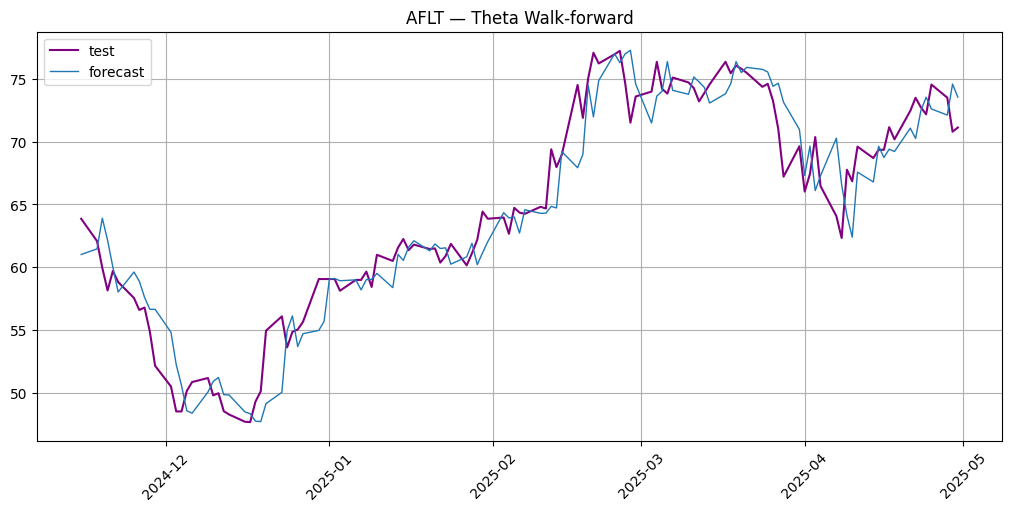

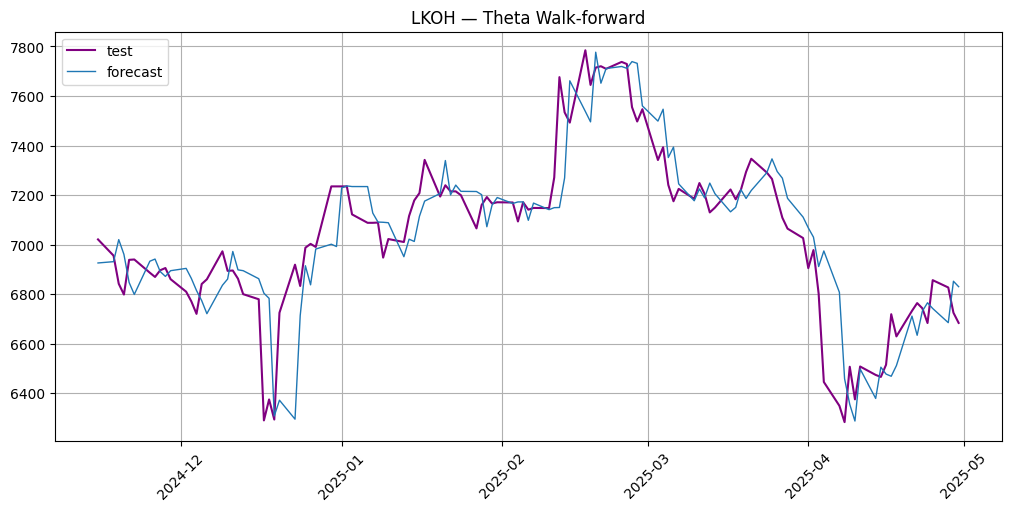

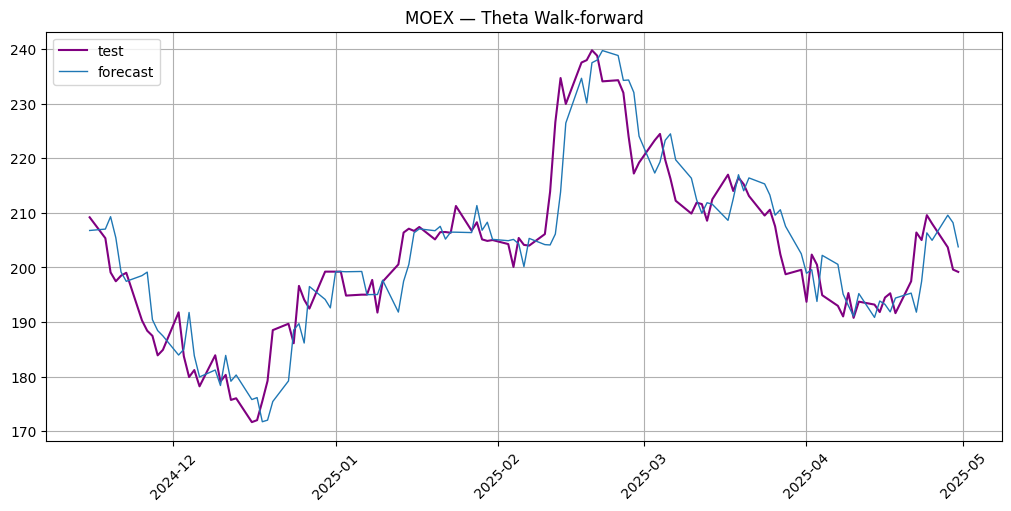

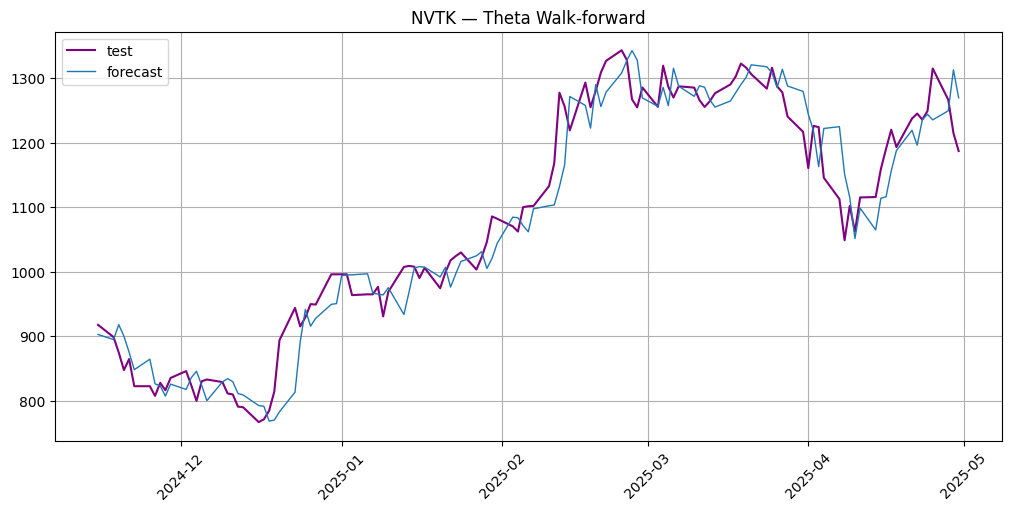

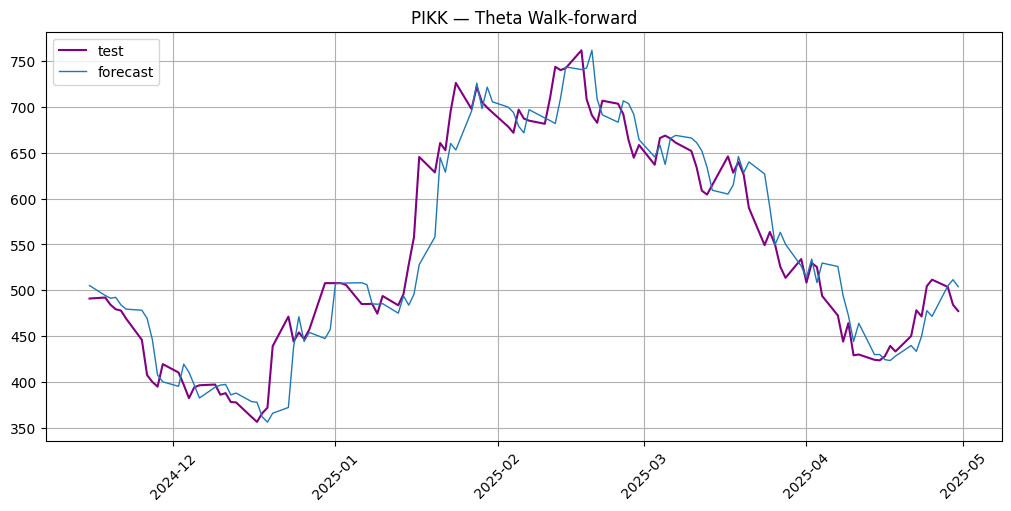

In [ ]:
results_map = {}

for ticker, (full_ts, train_ts, test_ts) in series.items():
    # 1) Собираем history_df из train_ts
    #    Получаем широкую таблицу и вынимаем нужную серию
    df_train_wide = train_ts.to_pandas(flatten=False)
    train_series = df_train_wide[(ticker, "target")]
    history_df = pd.DataFrame({
        "timestamp": train_series.index,
        "segment":   [ticker] * len(train_series),
        "target":    train_series.values
    })

    # 2) Готовим реальные значения теста
    df_test_wide = test_ts.to_pandas(flatten=False)
    y_test = df_test_wide[(ticker, "target")]

    preds = []
    times = []

    count = 0
    # 3) Walk-forward итерации по каждому таймстемпу в тесте
    for idx in y_test.index:
        #print(str(count) + " from " + str(len(y_test.index)))
        # 3.1) Формируем TSDataset из накопленного history_df
        history_ts = TSDataset(df=history_df.copy(), freq=train_ts.freq)

        # 3.2) Инициализируем AutoARIMA и меряем время fit+forecast на 1 шаг
        model = StatsForecastAutoThetaModel(
            season_length=5,              # 5 торговых дней в неделе
            decomposition_type='additive', # аддитивный разбор уровня+тренда
            model=None                     # пусть сам выберет внутри
        )
        t0 = time.time()
        model.fit(history_ts)
        forecast_step = model.predict(ts=history_ts)
        t1 = time.time()
        times.append(t1 - t0)

        # 3.3) Забираем предсказание последнего ряда
        df_forecast_wide = forecast_step.to_pandas(flatten=False)
        p = df_forecast_wide[(ticker, "target")].iloc[-1]
        preds.append(p)

        # 3.4) Добавляем в history_df реальное значение для следующего шага
        history_df = pd.concat([
            history_df,
            pd.DataFrame({
                "timestamp": [idx],
                "segment":   [ticker],
                "target":    [y_test.loc[idx]]
            })
        ], ignore_index=True)

        count += 1

    # 4) Собираем TSDataset из всех предсказаний
    forecast_df = pd.DataFrame({
        "timestamp": y_test.index.tolist(),
        "segment":   [ticker] * len(preds),
        "target":    preds
    })
    forecast_ts = TSDataset(df=forecast_df, freq=train_ts.freq)

    # 5) Считаем метрики
    mae_v   = MAE()(test_ts,   forecast_ts)[ticker]
    mape_v  = MAPE()(test_ts,  forecast_ts)[ticker]
    rmse_v  = RMSE()(test_ts,  forecast_ts)[ticker]
    smape_v = SMAPE()(test_ts, forecast_ts)[ticker]
    da_v    = directional_accuracy(y_test.values, np.array(preds))

    results_map[ticker] = {
        "MAE":       mae_v,
        "MAPE (%)":  mape_v,
        "RMSE":      rmse_v,
        "SMAPE (%)": smape_v,
        "DA (%)":    da_v,
        "Forecast time (s)": np.mean(times)
    }

    # 6) Визуализация
    plot_forecast(forecast_ts, test_ts)
    plt.title(f"{ticker} — Theta Walk-forward")
    plt.show()

# 7) Сводная таблица
metrics_df = pd.DataFrame.from_dict(results_map, orient="index")
metrics_df.loc["AVERAGE"] = metrics_df.mean(numeric_only=True)
metrics_df = metrics_df.round(3)

print("\n=== Итоговая таблица метрик Theta ===")
display(metrics_df)

# Линейные модели

## DLineral

## NLineral

# Рекурентные модели

## RNN

## LSTM